# Introducción

El transporte aéreo en EE.UU. es un sector crítico para la movilidad de personas y bienes.
Retrasos y cancelaciones generan costos para aerolíneas, pasajeros y economía en general. El dataset contiene información de vuelos en enero de 2023, con variables que permiten analizar qué rutas, aerolíneas y factores influyen más en los retrasos/cancelaciones.

# Objetivo principal

Analizar los retrasos y cancelaciones de vuelos en EE.UU. en enero de 2023 para identificar patrones, rutas críticas y causas frecuentes, con el fin de generar insights que ayuden a mejorar la planificación y gestión de aerolíneas.

# Preguntas a responder


1.   ¿Hay rutas que experimentan retrasos frecuentes?
2.   ¿Cuál es el tiempo promedio de retraso por ruta?
3.   ¿Es posible identificar las principales causas del retraso?
2.   ¿Existe algún origen o destino con más retrasos?





In [ ]:
# === Local file loader for Voilà / Jupyter (replaces Colab files.upload) ===
import os, io
import pandas as pd

# Expected files in the SAME folder as this notebook:
required_files = [
  "AIRLINE_CODE_DICTIONARY.csv",
  "DOT_CODE_DICTIONARY.xlsx",
  "flights_202301.csv",
  "flights_merged.csv"
]

missing = [f for f in required_files if not os.path.exists(f)]
print("Archivos esperados:", required_files)
if missing:
    print("\nFaltan estos archivos en la carpeta:", missing)
else:
    print("\nTodos los archivos están presentes.")

# Carga directa (ajusta nombres si los tuyos difieren)
def load_data():
    dfs = {}
    for f in required_files:
        ext = os.path.splitext(f)[1].lower()
        if ext == ".csv":
            dfs[os.path.splitext(f)[0]] = pd.read_csv(f)
        elif ext in (".xlsx", ".xls"):
            dfs[os.path.splitext(f)[0]] = pd.read_excel(f)
        else:
            print(f"Advertencia: extensión no manejada para {f}")
    return dfs

try:
    _dfs = load_data()
    # Ejemplos de acceso:
    # _dfs['flights_202301']  -> DataFrame de ese archivo
    # _dfs['DOT_CODE_DICTIONARY'] -> DataFrame Excel
    print("\nDataFrames cargados:", list(_dfs.keys()))
except Exception as e:
    print("Error al cargar archivos:", e)


In [ ]:
# === (Opcional) Subida de archivos con ipywidgets para Voilà ===
# Si no quieres copiar los archivos a la carpeta, puedes subirlos desde el navegador.
# Requiere: pip install ipywidgets
from ipywidgets import FileUpload, VBox, Button, Output, HTML
import os, pandas as pd, io

u = FileUpload(accept='.csv,.xlsx', multiple=True)
btn = Button(description='Guardar archivos subidos', button_style='success')
out = Output()

def on_click(_):
    with out:
        out.clear_output()
        if not u.value:
            print("No hay archivos subidos.")
            return
        saved = []
        for name, meta in u.value.items():
            with open(name, 'wb') as f:
                f.write(meta['content'])
            saved.append(name)
        print("Guardados:", saved)
        print("Vuelve a ejecutar la celda de carga local para leerlos en DataFrames.")

btn.on_click(on_click)
VBox([HTML("<b>Sube tus .csv / .xlsx y guárdalos:</b>"), u, btn, out])


Primero Importamos archivos

In [ ]:
import pandas as pd

dot_code_df, flights_df, airline_code_df = [
    pd.read_excel("DOT_CODE_DICTIONARY.xlsx"),
    pd.read_csv("flights_202301.csv"),
    pd.read_csv("AIRLINE_CODE_DICTIONARY.csv")
]

In [ ]:
dot_code_df.head()

,Code,Description
0,19031,Mackey International Inc.: MAC
1,19032,Munz Northern Airlines Inc.: XY
2,19033,Cochise Airlines Inc.: COC
3,19034,Golden Gate Airlines Inc.: GSA
4,19035,Aeromech Inc.: RZZ


Analizamos su estructura

In [ ]:
dot_code_df.shape

(1737, 2)

In [ ]:
flights_df.shape

(538837, 33)

In [ ]:
airline_code_df.shape

(1729, 2)

Validación de nulos

In [ ]:
dot_code_df.isnull().sum()

,0
Code,0
Description,4


In [ ]:
flights_df.isnull().sum()

,0
FL_DATE,0
AIRLINE_CODE,0
DOT_CODE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0
CRS_DEP_TIME,0
DEP_TIME,9978


In [ ]:
airline_code_df.isnull().sum()

,0
Code,1
Description,0


# Nulos

# Variables numéricas
Media (promedio): bueno si la distribución es simétrica (sin muchos outliers).


Mediana: mejor cuando hay valores atípicos o la distribución es sesgada.


Ceros: si el 0 tiene un significado (ejemplo: retraso en vuelos  0 = sin retraso).


# Variables categóricas
Moda (valor más frecuente): la opción más común.


Etiqueta especial como "Desconocido" o "No aplica": útil si quieres distinguir los nulos de los demás valores.

# Tratamiento de tablas:

## dot_code_df

* Description: categórica → reemplazar por "Desconocido".


##flights_df

* Variables numéricas de retrasos (DEP_DELAY, ARR_DELAY, DELAY_DUE_*, etc.):
  reemplazar por 0, porque significa no hubo retraso.


* Variables de tiempos (TAXI_IN, TAXI_OUT, AIR_TIME, etc.):
  usar mediana, porque los tiempos suelen tener outliers.


* Variables categóricas (CANCELLATION_CODE):
  "No aplica".


* Columnas con demasiados nulos (DELAY_DUE_* tienen >400k nulos):
 mantenerlas con 0, porque es información importante para análisis de demoras.


##airline_code_df

* La columna Code en airline_code_df corresponde a los códigos de aerolíneas (ejemplo: "AA", "DL", "UA"), asignándole un valor tipo "UNKNOWN" para mantener la fila y no perder la descripción asociada.


In [ ]:
# --- dot_code_df ---
dot_code_df['Description'] = dot_code_df['Description'].fillna("Desconocido")

# --- flights_df ---
# Reemplazar retrasos con 0 (varias columnas a la vez está OK)
delay_cols = ['DEP_DELAY','ARR_DELAY','DELAY_DUE_CARRIER','DELAY_DUE_WEATHER',
              'DELAY_DUE_NAS','DELAY_DUE_SECURITY','DELAY_DUE_LATE_AIRCRAFT']
flights_df[delay_cols] = flights_df[delay_cols].fillna(0)

# Reemplazar tiempos con la mediana (columna por columna, asignando de vuelta)
time_cols = ['DEP_TIME','TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
             'ARR_TIME','ELAPSED_TIME','AIR_TIME']
for col in time_cols:
    flights_df[col] = flights_df[col].fillna(flights_df[col].median())

# CRS_ELAPSED_TIME con la mediana
flights_df['CRS_ELAPSED_TIME'] = flights_df['CRS_ELAPSED_TIME'].fillna(
    flights_df['CRS_ELAPSED_TIME'].median()
)

# Categórica de cancelación
flights_df['CANCELLATION_CODE'] = flights_df['CANCELLATION_CODE'].replace("", "No aplica")
flights_df['CANCELLATION_CODE'] = flights_df['CANCELLATION_CODE'].fillna("No aplica")

# --- airline_code_df ---
airline_code_df['Code'] = airline_code_df['Code'].fillna("UNKNOWN")


Validar limpieza de nulos

In [ ]:
print(dot_code_df.isnull().sum())
print(flights_df.isnull().sum())
print(airline_code_df.isnull().sum())

Code           0
Description    0
dtype: int64
FL_DATE                    0
AIRLINE_CODE               0
DOT_CODE                   0
FL_NUMBER                  0
ORIGIN                     0
ORIGIN_CITY                0
DEST                       0
DEST_CITY                  0
CRS_DEP_TIME               0
DEP_TIME                   0
DEP_DELAY                  0
TAXI_OUT                   0
WHEELS_OFF                 0
WHEELS_ON                  0
TAXI_IN                    0
CRS_ARR_TIME               0
ARR_TIME                   0
ARR_DELAY                  0
CANCELLED                  0
CANCELLATION_CODE          0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ELAPSED_TIME               0
AIR_TIME                   0
DISTANCE                   0
DELAY_DUE_CARRIER          0
DELAY_DUE_WEATHER          0
DELAY_DUE_NAS              0
DELAY_DUE_SECURITY         0
DELAY_DUE_LATE_AIRCRAFT    0
FL_YEAR                    0
FL_MONTH                   0
FL_DAY                   

#Duplicados

Para primero identificar si había duplicados se uso el siguiente criterio


 Aquí no se trata de borrar “duplicados totales” (toda la fila idéntica), sino definir qué campos hacen que un registro deba ser único.

##dot_code_df

Clave: Code

Justificación: cada código DOT debe ser único, aunque su Description puede variar si hay inconsistencias.


##airline_code_df


Clave: Code


Justificación: cada aerolínea tiene un código único (ejemplo: "AA" = American Airlines).


##flights_df


Posibles claves:


FL_DATE, FL_NUMBER, AIRLINE_CODE, ORIGIN, DEST


Justificación: un vuelo en una fecha, con un número de vuelo y aerolínea, debe ser único.

<br>

*Nota: podrían existir casos donde una aerolínea repite número de vuelo en distintos días  por eso incluimos FL_DATE.*


In [ ]:
# --- dot_code_df ---
print("\n🔹 dot_code_df")
dups_dot = dot_code_df[dot_code_df.duplicated(subset=['Code'], keep=False)]
print(f"Duplicados encontrados: {dups_dot.shape[0]}")
display(dups_dot)

# --- airline_code_df ---
print("\n🔹 airline_code_df")
dups_airline = airline_code_df[airline_code_df.duplicated(subset=['Code'], keep=False)]
print(f"Duplicados encontrados: {dups_airline.shape[0]}")
display(dups_airline)

# --- flights_df ---
print("\n🔹 flights_df")
dups_flights = flights_df[flights_df.duplicated(subset=['FL_DATE','FL_NUMBER','AIRLINE_CODE','ORIGIN','DEST'], keep=False)]
print(f"Duplicados encontrados: {dups_flights.shape[0]}")
display(dups_flights.head(20))  # muestra solo los primeros 20 duplicados para no saturar



🔹 dot_code_df
Duplicados encontrados: 16


,Code,Description
1719,22114,Island Wings Ltd. Dba Island Wings Charter: IWQ
1720,22115,Swiss Private Jet S.A.: SWQ
1721,22116,Elangeni GmbH: ELQ
1722,22117,"Challenge Air Cargo, Ltd: X6"
1725,22120,Sparfell Malta Ltd: QFX
1726,22121,Haute Aviation: HUQ
1727,22122,AXIS Aviation Switzerland AG: XQQ
1728,22123,Western Air Ltd: WU
1729,22120,SPARFELL MALTA LTD: QFX
1730,22121,HAUTE AVIATION: HUQ



🔹 airline_code_df
Duplicados encontrados: 0


,Code,Description



🔹 flights_df
Duplicados encontrados: 0


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY


In [ ]:
# 1. Quitar filas con "DESCONOCIDO"
dot_code_df = dot_code_df[dot_code_df['Description'] != "DESCONOCIDO"]

# 2. Eliminar duplicados de Code, quedándote con la primera ocurrencia
dot_code_df = dot_code_df.drop_duplicates(subset=['Code'], keep='first')

# 3. Verificar que ya no estén
print(dot_code_df.loc[dot_code_df['Code'].isin([22114,22115,22116,22117,22120,22121,22122,22123])])

       Code                                      Description
1719  22114  Island Wings Ltd. Dba Island Wings Charter: IWQ
1720  22115                      Swiss Private Jet S.A.: SWQ
1721  22116                               Elangeni GmbH: ELQ
1722  22117                     Challenge Air Cargo, Ltd: X6
1725  22120                          Sparfell Malta Ltd: QFX
1726  22121                              Haute Aviation: HUQ
1727  22122                AXIS Aviation Switzerland AG: XQQ
1728  22123                              Western Air Ltd: WU


# Detectar y corregir valores atípicos en variables categóricas

  

🔹 1. dot_code_df


Solo revisar inconsistencias tipográficas simples:

Quitar espacios extra al inicio, final o dobles.



```
dot_code_df['Description'] = (
    dot_code_df['Description']
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)
```


🔹 2. airline_code_df

Solo limpiar la columna Description de espacios extra, sin cambiar mayúsculas/minúsculas.

```
airline_code_df['Description'] = (
    airline_code_df['Description']
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)
```

🔹 3. flights_df

Aquí se va a  estandarizar:

ORIGIN y DEST → deben ser códigos de aeropuerto en mayúsculas (ej. JFK, LAX).

ORIGIN_CITY y DEST_CITY → limpiar espacios repetidos y poner en mayúsculas para unificarlas.
```
# ORIGIN y DEST siempre en mayúsculas
flights_df['ORIGIN'] = flights_df['ORIGIN'].str.upper().str.strip()
flights_df['DEST']   = flights_df['DEST'].str.upper().str.strip()

# ORIGIN_CITY y DEST_CITY en mayúsculas + espacios consistentes
flights_df['ORIGIN_CITY'] = (
    flights_df['ORIGIN_CITY']
    .str.upper()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

flights_df['DEST_CITY'] = (
    flights_df['DEST_CITY']
    .str.upper()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
```


In [ ]:
# --- dot_code_df ---
print("\n🔹 dot_code_df fuera de alcance:")
print("Descripciones = 'Desconocido'")
display(dot_code_df[dot_code_df['Description'] == "DESCONOCIDO"])

print("\nCodes que no aparecen en flights_df")
codes_not_used = dot_code_df[~dot_code_df['Code'].isin(flights_df['DOT_CODE'].unique())]
print(f"Total: {codes_not_used.shape[0]}")
display(codes_not_used.head(20))

# --- airline_code_df ---
print("\n🔹 airline_code_df fuera de alcance:")
print("Codes = 'UNKNOWN'")
display(airline_code_df[airline_code_df['Code'] == "UNKNOWN"])

print("\nAerolíneas que no aparecen en flights_df")
airlines_not_used = airline_code_df[~airline_code_df['Code'].isin(flights_df['AIRLINE_CODE'].unique())]
print(f"Total: {airlines_not_used.shape[0]}")
display(airlines_not_used.head(20))

# --- flights_df ---
print("\n🔹 flights_df fuera de alcance:")

# Retrasos fuera de ±24h
bad_delay = flights_df[
    (~flights_df['DEP_DELAY'].between(-1440,1440)) |
    (~flights_df['ARR_DELAY'].between(-1440,1440))
]
print(f"Retrasos extremos: {bad_delay.shape[0]}")
display(bad_delay.head(10))

# Distancia anómala
bad_distance = flights_df[~flights_df['DISTANCE'].between(1,10000)]
print(f"Distancia fuera de rango: {bad_distance.shape[0]}")
display(bad_distance.head(10))

# Tiempo en aire anómalo
bad_airtime = flights_df[~flights_df['AIR_TIME'].between(1,1440)]
print(f"Tiempo en aire fuera de rango: {bad_airtime.shape[0]}")
display(bad_airtime.head(10))

# Códigos de cancelación inválidos
valid_cancel = ["A","B","C","D","No aplica"]
bad_cancel = flights_df[~flights_df['CANCELLATION_CODE'].isin(valid_cancel)]
print(f"Códigos de cancelación inválidos: {bad_cancel.shape[0]}")
display(bad_cancel.head(10))



🔹 dot_code_df fuera de alcance:
Descripciones = 'Desconocido'


,Code,Description



Codes que no aparecen en flights_df
Total: 1714


,Code,Description
0,19031,Mackey International Inc.: MAC
1,19032,Munz Northern Airlines Inc.: XY
2,19033,Cochise Airlines Inc.: COC
3,19034,Golden Gate Airlines Inc.: GSA
4,19035,Aeromech Inc.: RZZ
5,19036,Golden West Airlines Co.: GLW
6,19037,Puerto Rico Intl Airlines: PRN
7,19038,Air America Inc.: STZ
8,19039,Swift Aire Lines Inc.: SWT
9,19040,American Central Airlines: TSF



🔹 airline_code_df fuera de alcance:
Codes = 'UNKNOWN'


,Code,Description
1045,UNKNOWN,North American Airlines



Aerolíneas que no aparecen en flights_df
Total: 1714


,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
5,09Q,"Swift Air, LLC d/b/a Eastern Air Lines d/b/a E..."
6,0BQ,DCA
7,0CQ,ACM AIR CHARTER GmbH
8,0FQ,"Maine Aviation Aircraft Charter, LLC"
9,0GQ,"Inter Island Airways, d/b/a Inter Island Air"



🔹 flights_df fuera de alcance:
Retrasos extremos: 45


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY
20076,2023-01-03,AA,19805,369,SNA,"Santa Ana, CA",JFK,"New York, NY",1400,834.0,...,275.0,2454,2554.0,0.0,3.0,0.0,0.0,2023,1,3
22557,2023-01-04,AA,19805,459,SEA,"Seattle, WA",PHX,"Phoenix, AZ",500,531.0,...,161.0,1107,1471.0,0.0,20.0,0.0,0.0,2023,1,4
23384,2023-01-05,AA,19805,489,AMA,"Amarillo, TX",DFW,"Dallas/Fort Worth, TX",605,1009.0,...,51.0,312,1684.0,0.0,7.0,0.0,0.0,2023,1,5
23549,2023-01-01,AA,19805,496,GRR,"Grand Rapids, MI",DFW,"Dallas/Fort Worth, TX",710,911.0,...,139.0,931,1554.0,0.0,0.0,0.0,0.0,2023,1,1
25061,2023-01-22,AA,19805,1518,PBI,"West Palm Beach/Palm Beach, FL",CLT,"Charlotte, NC",800,1807.0,...,86.0,590,2047.0,0.0,14.0,0.0,0.0,2023,1,22
29193,2023-01-29,AA,19805,1662,SEA,"Seattle, WA",PHX,"Phoenix, AZ",815,1208.0,...,137.0,1107,909.0,0.0,0.0,0.0,758.0,2023,1,29
29842,2023-01-14,AA,19805,1681,MEM,"Memphis, TN",PHX,"Phoenix, AZ",712,1137.0,...,182.0,1264,1688.0,0.0,0.0,0.0,0.0,2023,1,14
41746,2023-01-03,AA,19805,589,SBA,"Santa Barbara, CA",DFW,"Dallas/Fort Worth, TX",540,804.0,...,159.0,1316,1581.0,0.0,0.0,0.0,0.0,2023,1,3
43603,2023-01-26,AA,19805,656,SRQ,"Sarasota/Bradenton, FL",CLT,"Charlotte, NC",800,848.0,...,81.0,547,1481.0,0.0,0.0,0.0,0.0,2023,1,26
47375,2023-01-19,AA,19805,830,LAS,"Las Vegas, NV",CLT,"Charlotte, NC",930,2300.0,...,205.0,1916,2229.0,0.0,0.0,0.0,0.0,2023,1,19


Distancia fuera de rango: 0


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY


Tiempo en aire fuera de rango: 0


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY


Códigos de cancelación inválidos: 528542


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY
0,2023-01-02,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,757.0,...,25.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,2
1,2023-01-03,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,755.0,...,37.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,3
2,2023-01-04,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,755.0,...,28.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,4
3,2023-01-05,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,754.0,...,38.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,5
4,2023-01-06,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,759.0,...,28.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,6
5,2023-01-07,9E,20363,4628,BDL,"Hartford, CT",LGA,"New York, NY",800,750.0,...,38.0,101,0.0,0.0,0.0,0.0,0.0,2023,1,7
6,2023-01-14,9E,20363,4628,LGA,"New York, NY",CVG,"Cincinnati, OH",1500,1452.0,...,85.0,585,0.0,0.0,0.0,0.0,0.0,2023,1,14
7,2023-01-21,9E,20363,4628,LGA,"New York, NY",CVG,"Cincinnati, OH",1500,1450.0,...,104.0,585,0.0,0.0,0.0,0.0,0.0,2023,1,21
8,2023-01-28,9E,20363,4628,LGA,"New York, NY",CVG,"Cincinnati, OH",1500,1455.0,...,106.0,585,0.0,0.0,0.0,0.0,0.0,2023,1,28
9,2023-01-09,9E,20363,4629,LGA,"New York, NY",BGM,"Binghamton, NY",2129,2122.0,...,33.0,147,0.0,0.0,0.0,0.0,0.0,2023,1,9


In [ ]:
# --- flights_df ---
# Retrasos extremos: conservarlos
# Distancia y AIR_TIME ya están bien
# Códigos de cancelación: normalizar
valid_cancel = ["A","B","C","D","No aplica"]
flights_df['CANCELLATION_CODE'] = flights_df['CANCELLATION_CODE'].where(
    flights_df['CANCELLATION_CODE'].isin(valid_cancel),
    other="No aplica"
)

In [ ]:
print(flights_df['CANCELLATION_CODE'].value_counts())


CANCELLATION_CODE
No aplica    528542
B              6611
C              1792
A              1707
D               185
Name: count, dtype: int64


In [ ]:
dot_code_df['Description'] = (
    dot_code_df['Description']
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)


In [ ]:
airline_code_df['Description'] = (
    airline_code_df['Description']
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)


In [ ]:
# ORIGIN y DEST siempre en mayúsculas
flights_df['ORIGIN'] = flights_df['ORIGIN'].str.upper().str.strip()
flights_df['DEST']   = flights_df['DEST'].str.upper().str.strip()

# ORIGIN_CITY y DEST_CITY en mayúsculas + espacios consistentes
flights_df['ORIGIN_CITY'] = (
    flights_df['ORIGIN_CITY']
    .str.upper()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

flights_df['DEST_CITY'] = (
    flights_df['DEST_CITY']
    .str.upper()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)


#Detectar y corregir valores atípicos en variables numéricas

Para dot_code_df y airline_code_df
Sus variables principales (Code) son identificadores, no métricas no aplica análisis de outliers numéricos.


Aquí no debemos detectar valores extremos porque no tienen sentido (ej. un Code muy grande no es outlier, es simplemente un ID).


Conclusión: no aplica outlier detection en estas dos.

##Para flights_df
Aquí sí tenemos muchas variables numéricas relevantes:
* Delays: DEP_DELAY, ARR_DELAY
* Times: TAXI_OUT, TAXI_IN, ELAPSED_TIME, AIR_TIME
* Distance: DISTANCE


In [ ]:
import numpy as np

numeric_cols = ['DEP_DELAY','ARR_DELAY','TAXI_OUT','TAXI_IN','ELAPSED_TIME','AIR_TIME','DISTANCE']

outlier_summary = {}

for col in numeric_cols:
    data = flights_df[col].dropna()

    # Z-score
    z_scores = (data - data.mean()) / data.std(ddof=0)
    z_outliers = data[np.abs(z_scores) > 3]

    # IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]

    outlier_summary[col] = {
        "total": data.shape[0],
        "z_outliers": z_outliers.shape[0],
        "iqr_outliers": iqr_outliers.shape[0],
        "min": data.min(),
        "max": data.max()
    }

import pandas as pd
pd.DataFrame(outlier_summary).T


,total,z_outliers,iqr_outliers,min,max
DEP_DELAY,538837.0,7838.0,69716.0,-52.0,3024.0
ARR_DELAY,538837.0,7650.0,51102.0,-80.0,3063.0
TAXI_OUT,538837.0,10480.0,35661.0,1.0,222.0
TAXI_IN,538837.0,10083.0,36666.0,1.0,173.0
ELAPSED_TIME,538837.0,8137.0,27476.0,17.0,749.0
AIR_TIME,538837.0,8742.0,28694.0,8.0,695.0
DISTANCE,538837.0,4831.0,32099.0,31.0,5095.0


In [ ]:
# --- Detectar outliers Taxi times (>120 min) ---

cols_to_show = [
    'FL_DATE','AIRLINE_CODE','DOT_CODE','FL_NUMBER',
    'ORIGIN','ORIGIN_CITY','DEST','DEST_CITY',
    'TAXI_OUT','TAXI_IN'
]

# Filtrar casos sospechosos
taxi_outliers = flights_df[flights_df['TAXI_OUT'] > 120][cols_to_show]
taxi_in_outliers = flights_df[flights_df['TAXI_IN'] > 120][cols_to_show]

# Contar cuántos son
print("🚕 Taxi-out >120 min:", taxi_outliers.shape[0])
print("🚕 Taxi-in >120 min:", taxi_in_outliers.shape[0])

# Mostrar ejemplos
print("\nEjemplos Taxi-out >120 min:")
display(taxi_outliers.head(10))

print("\nEjemplos Taxi-in >120 min:")
display(taxi_in_outliers.head(10))


🚕 Taxi-out >120 min: 218
🚕 Taxi-in >120 min: 28

Ejemplos Taxi-out >120 min:


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,TAXI_OUT,TAXI_IN
111,2023-01-04,9E,20363,4634,MSP,"MINNEAPOLIS, MN",PIT,"PITTSBURGH, PA",158.0,2.0
477,2023-01-04,9E,20363,4652,MSP,"MINNEAPOLIS, MN",CVG,"CINCINNATI, OH",155.0,4.0
608,2023-01-31,9E,20363,4658,LGA,"NEW YORK, NY",CVG,"CINCINNATI, OH",126.0,4.0
3048,2023-01-04,9E,20363,4741,MSP,"MINNEAPOLIS, MN",ATW,"APPLETON, WI",123.0,6.0
3769,2023-01-12,9E,20363,4768,ATL,"ATLANTA, GA",HPN,"WHITE PLAINS, NY",133.0,5.0
4443,2023-01-31,9E,20363,4793,JFK,"NEW YORK, NY",BNA,"NASHVILLE, TN",140.0,10.0
4566,2023-01-04,9E,20363,4798,MSP,"MINNEAPOLIS, MN",GRB,"GREEN BAY, WI",121.0,4.0
4974,2023-01-19,9E,20363,4811,GRB,"GREEN BAY, WI",MSP,"MINNEAPOLIS, MN",127.0,8.0
5003,2023-01-31,9E,20363,4812,LGA,"NEW YORK, NY",RDU,"RALEIGH/DURHAM, NC",145.0,4.0
6550,2023-01-31,9E,20363,4886,LGA,"NEW YORK, NY",MEM,"MEMPHIS, TN",130.0,3.0



Ejemplos Taxi-in >120 min:


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,TAXI_OUT,TAXI_IN
10554,2023-01-15,9E,20363,5135,CLE,"CLEVELAND, OH",JFK,"NEW YORK, NY",19.0,133.0
19238,2023-01-12,AA,19805,335,MIA,"MIAMI, FL",EWR,"NEWARK, NJ",12.0,147.0
21151,2023-01-07,AA,19805,414,ORD,"CHICAGO, IL",IAH,"HOUSTON, TX",19.0,121.0
57977,2023-01-12,AA,19805,2918,ORD,"CHICAGO, IL",EWR,"NEWARK, NJ",27.0,163.0
76199,2023-01-12,AA,19805,2333,PHX,"PHOENIX, AZ",EWR,"NEWARK, NJ",18.0,133.0
110860,2023-01-30,AS,19930,825,SEA,"SEATTLE, WA",OGG,"KAHULUI, HI",19.0,125.0
114361,2023-01-04,B6,20409,1097,BOS,"BOSTON, MA",ATL,"ATLANTA, GA",16.0,136.0
140451,2023-01-21,DL,19790,464,LAX,"LOS ANGELES, CA",OGG,"KAHULUI, HI",12.0,173.0
157985,2023-01-22,DL,19790,2817,BNA,"NASHVILLE, TN",BOS,"BOSTON, MA",19.0,129.0
159277,2023-01-19,DL,19790,562,LAX,"LOS ANGELES, CA",JFK,"NEW YORK, NY",22.0,125.0


In [ ]:
# Calcular la mediana de TAXI_IN
taxi_in_median = flights_df['TAXI_IN'].median()

# Contar antes cuántos casos hay >120
outliers_taxi_in = flights_df[flights_df['TAXI_IN'] > 120].shape[0]
print("🚕 Taxi-in >120 antes de imputar:", outliers_taxi_in)

# Reemplazar outliers con la mediana
flights_df.loc[flights_df['TAXI_IN'] > 120, 'TAXI_IN'] = taxi_in_median

# Verificar que ya no existan >120
outliers_after = flights_df[flights_df['TAXI_IN'] > 120].shape[0]
print("🚕 Taxi-in >120 después de imputar:", outliers_after)
print("Mediana usada:", taxi_in_median)


🚕 Taxi-in >120 antes de imputar: 28
🚕 Taxi-in >120 después de imputar: 0
Mediana usada: 6.0


In [ ]:
# --- Detectar vuelos con AIR_TIME o ELAPSED_TIME > 720 min (12h) ---

cols_to_show = [
    'FL_DATE','AIRLINE_CODE','DOT_CODE','FL_NUMBER',
    'ORIGIN','ORIGIN_CITY','DEST','DEST_CITY',
    'AIR_TIME','ELAPSED_TIME'
]

# Filtrar casos sospechosos
airtime_outliers = flights_df[flights_df['AIR_TIME'] > 720][cols_to_show]
elapsed_outliers = flights_df[flights_df['ELAPSED_TIME'] > 720][cols_to_show]

# Agregar banderas al dataframe principal (sin borrar nada todavía)
flights_df['AIRTIME_OUTLIER'] = flights_df['AIR_TIME'] > 720
flights_df['ELAPSED_OUTLIER'] = flights_df['ELAPSED_TIME'] > 720

# Contar cuántos son
print("✈️ AIR_TIME >720 min:", airtime_outliers.shape[0])
print("✈️ ELAPSED_TIME >720 min:", elapsed_outliers.shape[0])

# Mostrar ejemplos
print("\nEjemplos AIR_TIME >720 min:")
display(airtime_outliers.head(10))

print("\nEjemplos ELAPSED_TIME >720 min:")
display(elapsed_outliers.head(10))


✈️ AIR_TIME >720 min: 0
✈️ ELAPSED_TIME >720 min: 6

Ejemplos AIR_TIME >720 min:


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,AIR_TIME,ELAPSED_TIME



Ejemplos ELAPSED_TIME >720 min:


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,AIR_TIME,ELAPSED_TIME
135423,2023-01-10,DL,19790,312,JFK,"NEW YORK, NY",HNL,"HONOLULU, HI",695.0,722.0
135424,2023-01-11,DL,19790,312,JFK,"NEW YORK, NY",HNL,"HONOLULU, HI",660.0,721.0
135444,2023-01-31,DL,19790,312,JFK,"NEW YORK, NY",HNL,"HONOLULU, HI",688.0,749.0
233422,2023-01-31,HA,19690,51,JFK,"NEW YORK, NY",HNL,"HONOLULU, HI",661.0,722.0
233959,2023-01-12,HA,19690,89,BOS,"BOSTON, MA",HNL,"HONOLULU, HI",694.0,724.0
494594,2023-01-14,UA,19977,42,EWR,"NEWARK, NJ",OGG,"KAHULUI, HI",666.0,734.0


#Verificar y cambiar tipos de datos

Se realizo la siguiente consulta para identificar los valores de las tablas

In [ ]:
import pandas as pd

print("=== dot_code_df: dtypes ===")
print(dot_code_df.dtypes)
print("\nNulls por columna:")
print(dot_code_df.isnull().sum())

print("\n=== airline_code_df: dtypes ===")
print(airline_code_df.dtypes)
print("\nNulls por columna:")
print(airline_code_df.isnull().sum())

print("\n=== flights_df: dtypes ===")
print(flights_df.dtypes)
print("\nNulls por columna:")
print(flights_df.isnull().sum())


=== dot_code_df: dtypes ===
Code            int64
Description    object
dtype: object

Nulls por columna:
Code           0
Description    0
dtype: int64

=== airline_code_df: dtypes ===
Code           object
Description    object
dtype: object

Nulls por columna:
Code           0
Description    0
dtype: int64

=== flights_df: dtypes ===
FL_DATE                     object
AIRLINE_CODE                object
DOT_CODE                     int64
FL_NUMBER                    int64
ORIGIN                      object
ORIGIN_CITY                 object
DEST                        object
DEST_CITY                   object
CRS_DEP_TIME                 int64
DEP_TIME                   float64
DEP_DELAY                  float64
TAXI_OUT                   float64
WHEELS_OFF                 float64
WHEELS_ON                  float64
TAXI_IN                    float64
CRS_ARR_TIME                 int64
ARR_TIME                   float64
ARR_DELAY                  float64
CANCELLED                    in

##dot_code_df
* Code → int64 ❌ → debería ser string, porque es un identificador, no un número para cálculos.

* Description → object ✅ correcto (texto).

##airline_code_df
* Code → object ✅ ya es texto (ej. "AA", "DL", "UNKNOWN").
* Description → object ✅ correcto (texto).
Aquí no hace falta cambiar nada.


##flights_df
* FL_DATE → object ❌ → debería ser datetime para cálculos de fechas.

* AIRLINE_CODE → object ✅ (string de aerolínea).

* DOT_CODE → int64 ❌ → debería ser string (identificador).

* FL_NUMBER → int64 ❌ → mejor como string, para no perder ceros iniciales.

* ORIGIN / DEST → object ✅ (códigos de aeropuerto).

* ORIGIN_CITY / DEST_CITY → object ✅ (nombres de ciudades).

* CRS_DEP_TIME, CRS_ARR_TIME → int64 ⚠️ → son horas en formato HHMM; conviene tratarlos como string o convertirlos a time si quieres cálculos.

* DEP_TIME, ARR_TIME, WHEELS_OFF, WHEELS_ON → float64 ⚠️ → deberían ser enteros HHMM, pero se volvieron floats por nulos. Lo ideal es cast a string o int, según lo uses.

* Delays / Taxi / Elapsed / Distance → float64/int64 ✅ correcto (numéricos).

* CANCELLED, DIVERTED → int64 ❌ → deberían ser boolean.

* CANCELLATION_CODE → object ✅ (categoría).

* FL_YEAR, FL_MONTH, FL_DAY → int64 ✅ correcto.

* AIRTIME_OUTLIER, ELAPSED_OUTLIER → bool ✅ correcto.


In [ ]:
import pandas as pd

# ===== dot_code_df → dot_code_typed =====
dot_code_typed = dot_code_df.copy()
dot_code_typed['Code'] = dot_code_typed['Code'].astype(str)   # ID → string

# ===== airline_code_df → airline_code_typed =====
# (no cambia tipos, solo clonamos para consistencia)
airline_code_typed = airline_code_df.copy()

# ===== flights_df → flights_typed =====
flights_typed = flights_df.copy()

# Fechas / IDs
flights_typed['FL_DATE']   = pd.to_datetime(flights_typed['FL_DATE'], errors='coerce')  # fecha real
flights_typed['DOT_CODE']  = flights_typed['DOT_CODE'].astype(str)   # ID → string
flights_typed['FL_NUMBER'] = flights_typed['FL_NUMBER'].astype(str)  # identificador → string (sin perder ceros)

# Booleanos
flights_typed['CANCELLED'] = flights_typed['CANCELLED'].astype(bool)
flights_typed['DIVERTED']  = flights_typed['DIVERTED'].astype(bool)

# (Opcional) Si quieres que los HHMM programados queden como texto con 4 dígitos:
# flights_typed['CRS_DEP_TIME'] = flights_typed['CRS_DEP_TIME'].astype(str).str.zfill(4)
# flights_typed['CRS_ARR_TIME'] = flights_typed['CRS_ARR_TIME'].astype(str).str.zfill(4)

# ===== verificación rápida =====
print("dot_code_typed dtypes:\n", dot_code_typed.dtypes, "\n")
print("airline_code_typed dtypes:\n", airline_code_typed.dtypes, "\n")
print("flights_typed dtypes:\n", flights_typed.dtypes.head(20))


dot_code_typed dtypes:
 Code           object
Description    object
dtype: object 

airline_code_typed dtypes:
 Code           object
Description    object
dtype: object 

flights_typed dtypes:
 FL_DATE              datetime64[ns]
AIRLINE_CODE                 object
DOT_CODE                     object
FL_NUMBER                    object
ORIGIN                       object
ORIGIN_CITY                  object
DEST                         object
DEST_CITY                    object
CRS_DEP_TIME                  int64
DEP_TIME                    float64
DEP_DELAY                   float64
TAXI_OUT                    float64
WHEELS_OFF                  float64
WHEELS_ON                   float64
TAXI_IN                     float64
CRS_ARR_TIME                  int64
ARR_TIME                    float64
ARR_DELAY                   float64
CANCELLED                      bool
CANCELLATION_CODE            object
dtype: object


In [ ]:
# Calcular medianas de cada columna de tiempo (solo vuelos no cancelados)
time_cols = ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME','WHEELS_OFF','WHEELS_ON']
median_times = {}

for col in time_cols:
    valid = flights_typed.loc[~flights_typed['CANCELLED'], col].dropna()
    if not valid.empty:
        median_times[col] = int(valid.median())
    else:
        median_times[col] = None

def convert_hhmm_with_impute(value, col, cancelled):
    try:
        if pd.isna(value):
            if cancelled:   # si está cancelado → NaT
                return pd.NaT
            else:           # si no está cancelado → mediana de esa columna
                median_val = median_times.get(col, None)
                if median_val is None: return pd.NaT
                hours = median_val // 100
                minutes = median_val % 100
                return f"{hours:02d}:{minutes:02d}"
        value = int(value)
        hours = value // 100
        minutes = value % 100
        if hours < 24 and minutes < 60:
            return f"{hours:02d}:{minutes:02d}"
        else:
            return pd.NaT
    except:
        return pd.NaT

# Crear nuevas columnas con imputación
for col in time_cols:
    flights_typed[col + "_STR"] = flights_typed.apply(
        lambda row: convert_hhmm_with_impute(row[col], col, row['CANCELLED']),
        axis=1
    )


# Union de Tablas

In [ ]:
# Unir flights con DOT_CODE_DICTIONARY
flights_dot = flights_typed.merge(
    dot_code_typed,
    how="left",
    left_on="DOT_CODE",
    right_on="Code",
    suffixes=("", "_DOT")
)

# Renombrar para mayor claridad
flights_dot = flights_dot.rename(columns={"Description": "DOT_DESCRIPTION"})

# Unir flights con AIRLINE_CODE_DICTIONARY
flights_merged = flights_dot.merge(
    airline_code_typed,
    how="left",
    left_on="AIRLINE_CODE",
    right_on="Code",
    suffixes=("", "_AIRLINE")
)

# Renombrar
flights_merged = flights_merged.rename(columns={"Description": "AIRLINE_DESCRIPTION"})

# Vista rápida
print("Shape final:", flights_merged.shape)
display(flights_merged[['FL_DATE','AIRLINE_CODE','AIRLINE_DESCRIPTION',
                        'DOT_CODE','DOT_DESCRIPTION']].head(10))


Shape final: (538837, 45)


,FL_DATE,AIRLINE_CODE,AIRLINE_DESCRIPTION,DOT_CODE,DOT_DESCRIPTION
0,2023-01-02,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
1,2023-01-03,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
2,2023-01-04,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
3,2023-01-05,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
4,2023-01-06,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
5,2023-01-07,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
6,2023-01-14,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
7,2023-01-21,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
8,2023-01-28,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E
9,2023-01-09,9E,Endeavor Air Inc.,20363,Endeavor Air Inc.: 9E


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
# IMPORTANTE: leer el archivo del disco, no el dict
flights_merged = pd.read_csv("flights_merged.csv", low_memory=False)
print(type(flights_merged), flights_merged.shape)
flights_merged.head(2)


<class 'pandas.core.frame.DataFrame'> (538837, 45)


,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,CRS_DEP_TIME_STR,DEP_TIME_STR,CRS_ARR_TIME_STR,ARR_TIME_STR,WHEELS_OFF_STR,WHEELS_ON_STR,Code,DOT_DESCRIPTION,Code_AIRLINE,AIRLINE_DESCRIPTION
0,2023-01-02,9E,20363,4628,BDL,"HARTFORD, CT",LGA,"NEW YORK, NY",800,757.0,...,08:00,07:57,09:05,08:53,08:08,08:33,20363,Endeavor Air Inc.: 9E,9E,Endeavor Air Inc.
1,2023-01-03,9E,20363,4628,BDL,"HARTFORD, CT",LGA,"NEW YORK, NY",800,755.0,...,08:00,07:55,09:05,08:57,08:14,08:51,20363,Endeavor Air Inc.: 9E,9E,Endeavor Air Inc.


# Agrupar datos según variables categóricas



1. Candidatos a variables categóricas en flights_typed / flights_merged
Algunas opciones que tiene mucho sentido:
* AIRLINE_CODE o AIRLINE_DESCRIPTION → comparar aerolíneas.
* ORIGIN o ORIGIN_CITY → comparar aeropuertos de salida.
* DEST o DEST_CITY → comparar aeropuertos de llegada.
* CANCELLATION_CODE → analizar causas de cancelación.
* DIVERTED → vuelos desviados vs no desviados.
* FL_MONTH → patrones por mes. (no aplica porque solo son de enero)

 2. Variables numéricas relacionadas, sobre esas categorías podemos calcular:
* Conteos: número de vuelos.
* Promedios: retrasos medios (DEP_DELAY, ARR_DELAY), tiempos de rodaje (TAXI_OUT, TAXI_IN), distancia promedio.
* Porcentajes: proporción de vuelos cancelados o desviados.




In [ ]:
# Agrupar por aerolínea y calcular métricas
airline_summary = flights_merged.groupby("AIRLINE_DESCRIPTION").agg(
    total_vuelos = ("FL_NUMBER", "count"),
    promedio_dep_delay = ("DEP_DELAY", "mean"),
    promedio_arr_delay = ("ARR_DELAY", "mean"),
    promedio_taxi_out = ("TAXI_OUT", "mean"),
    promedio_taxi_in = ("TAXI_IN", "mean"),
    promedio_distancia = ("DISTANCE", "mean"),
    cancelados = ("CANCELLED", "sum"),
    desviados = ("DIVERTED", "sum")
).reset_index()

# Porcentajes
airline_summary["pct_cancelados"] = 100 * airline_summary["cancelados"] / airline_summary["total_vuelos"]
airline_summary["pct_desviados"] = 100 * airline_summary["desviados"] / airline_summary["total_vuelos"]

airline_summary.head(10)



,AIRLINE_DESCRIPTION,total_vuelos,promedio_dep_delay,promedio_arr_delay,promedio_taxi_out,promedio_taxi_in,promedio_distancia,cancelados,desviados,pct_cancelados,pct_desviados
0,Alaska Airlines Inc.,19801,6.288066,3.203424,20.240745,8.041210,1356.813797,280,100,1.414070,0.505025
1,Allegiant Air,8615,17.274869,15.551248,15.967150,7.367266,917.534185,115,22,1.334881,0.255369
2,American Airlines Inc.,74999,14.344031,10.564861,18.756610,8.699796,963.093508,1417,128,1.889359,0.170669
3,Delta Air Lines Inc.,75174,13.255833,6.338255,18.312169,8.262431,955.272780,586,169,0.779525,0.224812
4,Endeavor Air Inc.,16926,11.939620,7.081531,21.950431,8.163476,405.497400,249,40,1.471110,0.236323
5,Envoy Air,18849,8.437052,7.119317,19.487930,8.570959,518.466868,482,42,2.557165,0.222823
6,Frontier Airlines Inc.,13285,25.216861,20.382838,18.523673,11.357847,1025.177493,438,19,3.296951,0.143018
7,Hawaiian Airlines Inc.,6697,8.895177,9.020606,12.702255,8.837539,886.329700,72,9,1.075108,0.134389
8,JetBlue Airways,23249,16.748935,10.429137,19.355413,8.575939,1112.201901,194,77,0.834444,0.331197
9,PSA Airlines Inc.,15456,4.829387,0.550595,21.940606,7.853455,408.963056,250,41,1.617495,0.265269


In [ ]:
airport_summary = flights_merged.groupby("ORIGIN_CITY").agg(
    total_vuelos = ("FL_NUMBER", "count"),
    promedio_dep_delay = ("DEP_DELAY", "mean"),
    promedio_arr_delay = ("ARR_DELAY", "mean"),
    promedio_taxi_out = ("TAXI_OUT", "mean"),
    promedio_taxi_in = ("TAXI_IN", "mean"),
    cancelados = ("CANCELLED", "sum"),
    desviados = ("DIVERTED", "sum")
).reset_index()

airport_summary["pct_cancelados"] = 100 * airport_summary["cancelados"] / airport_summary["total_vuelos"]
airport_summary["pct_desviados"] = 100 * airport_summary["desviados"] / airport_summary["total_vuelos"]

display(airport_summary.sort_values("promedio_dep_delay", ascending=False).head(10))


,ORIGIN_CITY,total_vuelos,promedio_dep_delay,promedio_arr_delay,promedio_taxi_out,promedio_taxi_in,cancelados,desviados,pct_cancelados,pct_desviados
257,"RIVERTON/LANDER, WY",31,63.903226,66.645161,30.612903,8.677419,1,1,3.225806,3.225806
233,"PELLSTON, MI",52,57.192308,26.211538,18.557692,6.923077,3,1,5.769231,1.923077
221,"NORTH BEND/COOS BAY, OR",18,48.444444,43.000000,12.222222,5.055556,1,0,5.555556,0.000000
64,"CLARKSBURG/FAIRMONT, WV",10,44.200000,41.900000,9.400000,8.000000,0,0,0.000000,0.000000
246,"PRESCOTT, AZ",61,43.442623,44.311475,23.967213,8.918033,1,1,1.639344,1.639344
149,"JACKSON, WY",510,43.372549,33.007843,27.470588,9.303922,11,13,2.156863,2.549020
36,"BISHOP, CA",51,37.490196,15.960784,14.274510,9.098039,3,1,5.882353,1.960784
97,"ESCANABA, MI",61,37.196721,34.754098,20.344262,6.639344,3,2,4.918033,3.278689
295,"SPRINGFIELD, IL",59,36.508475,27.322034,12.966102,9.084746,2,0,3.389831,0.000000
308,"TEXARKANA, AR",90,36.044444,37.422222,14.733333,12.077778,3,0,3.333333,0.000000


In [ ]:
month_summary = flights_merged.groupby("FL_MONTH").agg(
    total_vuelos = ("FL_NUMBER", "count"),
    promedio_dep_delay = ("DEP_DELAY", "mean"),
    promedio_arr_delay = ("ARR_DELAY", "mean"),
    promedio_taxi_out = ("TAXI_OUT", "mean"),
    promedio_taxi_in = ("TAXI_IN", "mean"),
    cancelados = ("CANCELLED", "sum"),
    desviados = ("DIVERTED", "sum")
).reset_index()

month_summary["pct_cancelados"] = 100 * month_summary["cancelados"] / month_summary["total_vuelos"]
month_summary["pct_desviados"] = 100 * month_summary["desviados"] / month_summary["total_vuelos"]

display(month_summary.sort_values("FL_MONTH"))




,FL_MONTH,total_vuelos,promedio_dep_delay,promedio_arr_delay,promedio_taxi_out,promedio_taxi_in,cancelados,desviados,pct_cancelados,pct_desviados
0,1,538837,12.697584,7.608407,18.271462,7.991446,10295,1345,1.910596,0.249612


In [ ]:
with pd.ExcelWriter("summaries.xlsx") as writer:
    airline_summary.to_excel(writer, sheet_name="Aerolíneas", index=False)
    airport_summary.to_excel(writer, sheet_name="Aeropuertos", index=False)
    month_summary.to_excel(writer, sheet_name="Meses", index=False)


# En Voilà/Jupyter, ofrece un enlace de descarga en lugar de files.download
from IPython.display import FileLink, display
display(FileLink("summaries.xlsx", result_html_prefix="Descargar ► "))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analizar variables categóricas

 a) Distribución de vuelos por aerolínea (barras)


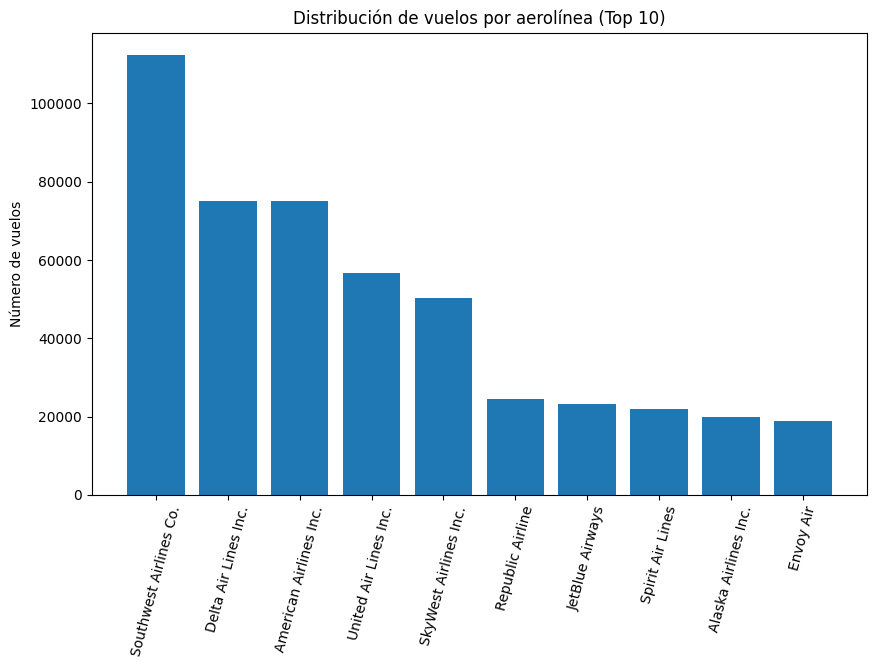

In [ ]:
import matplotlib.pyplot as plt

# Top 10 aerolíneas por número de vuelos
top_airlines = airline_summary.sort_values("total_vuelos", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_airlines["AIRLINE_DESCRIPTION"], top_airlines["total_vuelos"])
plt.xticks(rotation=75)
plt.ylabel("Número de vuelos")
plt.title("Distribución de vuelos por aerolínea (Top 10)")
plt.show()


Interpretación del gráfico

* Southwest Airlines Co. destaca con mucha diferencia: supera los 110,000 vuelos, lo que la coloca como líder indiscutible en número de operaciones.

* Delta Air Lines Inc. y American Airlines Inc. están en un segundo nivel, con valores similares, alrededor de 75,000 vuelos cada una, mostrando un peso importante pero aún muy por debajo de Southwest.

* United Air Lines Inc. y SkyWest Airlines Inc. siguen en el ranking con cifras intermedias (entre 50,000 y 57,000 vuelos).

* El resto de aerolíneas (Republic, JetBlue, Spirit, Alaska, Envoy) tienen un número bastante menor, en el rango de 20,000–25,000 vuelos, lo que las ubica claramente en un tercer nivel competitivo.
<br>

Conclusiones principales

* Concentración en pocas aerolíneas:
La mayor parte de los vuelos se concentra en tres grandes jugadores (Southwest, Delta y American). En conjunto, representan más del 60% del total de vuelos del top 10.

* Liderazgo de Southwest:
Su ventaja sobre las demás es amplia (casi 50% más que Delta o American). Esto refleja un modelo de negocio basado en volumen y rutas domésticas frecuentes.

* Brecha significativa entre niveles:

  * Nivel 1: Southwest (dominante).

  * Nivel 2: Delta y American (competidores fuertes).
  * Nivel 3: United y SkyWest (importantes pero con menor alcance).
  * Nivel 4: Republic, JetBlue, Spirit, Alaska y Envoy (operadores medianos o de nicho).
<br>

Estrategias diferenciadas:

* Las aerolíneas grandes (Southwest, Delta, American, United) basan su ventaja en amplias redes y cobertura nacional/internacional.

* Las más pequeñas probablemente se enfocan en mercados regionales o segmentos específicos.
<br>

Implicaciones para el negocio

* Competencia alta en el top 3: Cualquier análisis de mercado, alianzas o evaluación de retrasos/incidencias debe prestar atención a estas tres aerolíneas, porque concentran el volumen.

* Oportunidad en regionales: Aerolíneas más pequeñas podrían crecer si se enfocan en rutas donde los grandes no tienen tanta cobertura o ajustando precios.

* Impacto en usuarios: La elección de vuelos de la mayoría de los pasajeros estará vinculada a estas tres aerolíneas principales, lo que también influye en calidad de servicio y experiencia.

 b) Proporción de vuelos por dia

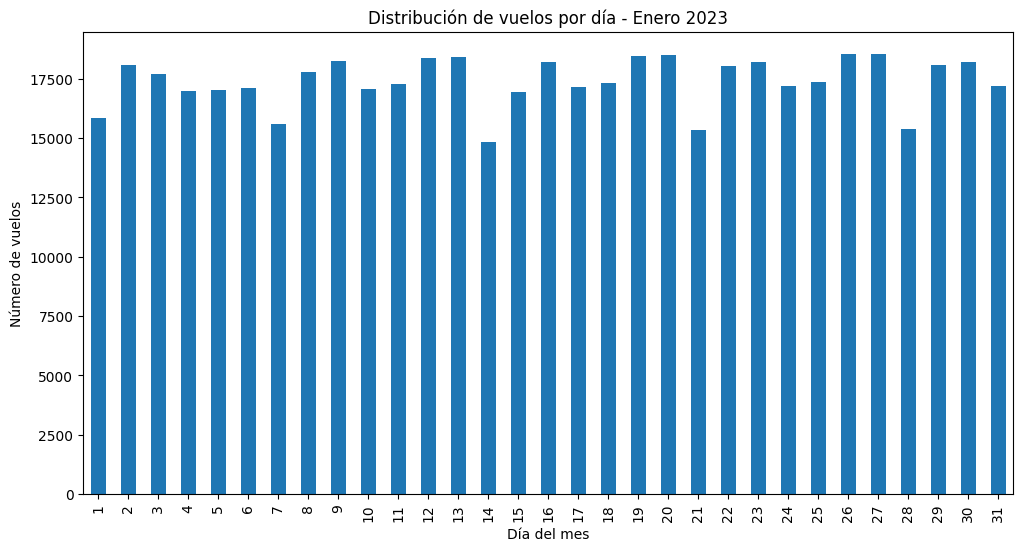

In [ ]:
plt.figure(figsize=(12,6))
flights_merged.groupby("FL_DAY")["FL_NUMBER"].count().plot(kind="bar")
plt.title("Distribución de vuelos por día - Enero 2023")
plt.xlabel("Día del mes")
plt.ylabel("Número de vuelos")
plt.show()



Análisis vuelos por día – Enero 2023

* Promedio diario: 16,000–19,000 vuelos.

* Estable a lo largo del mes, sin caídas bruscas.

* Menos vuelos en sábados (7, 14, 21, 28 y 29), alrededor de 15,000–15,500.

* Más vuelos jueves y viernes, superando los 18,500.

Conclusiones

* La operación es constante, con ajustes según la semana.

* Se observa un patrón laboral: más vuelos entre semana, menos en fin de semana.

* Esto sugiere oportunidades para optimizar recursos y promociones en días bajos.

 b.1) Proporción de vuelos por semana



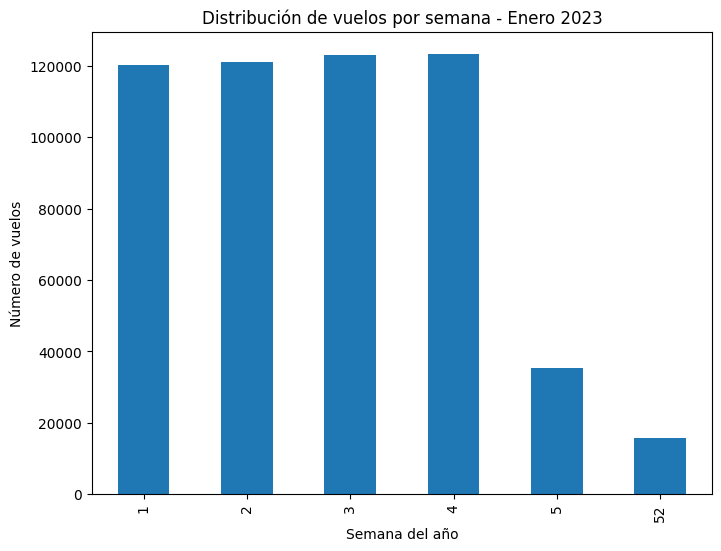

In [ ]:
# Asegurar que la fecha esté en formato datetime
flights_merged["FL_DATE"] = pd.to_datetime(flights_merged["FL_DATE"], errors="coerce")

# Crear columna de semana
flights_merged["WEEK"] = flights_merged["FL_DATE"].dt.isocalendar().week

# Agrupar por semana
plt.figure(figsize=(8,6))
flights_merged.groupby("WEEK")["FL_NUMBER"].count().plot(kind="bar")
plt.title("Distribución de vuelos por semana - Enero 2023")
plt.xlabel("Semana del año")
plt.ylabel("Número de vuelos")
plt.show()


In [ ]:
punctuality = airline_summary.sort_values("promedio_arr_delay")
display(punctuality[["AIRLINE_DESCRIPTION","promedio_arr_delay"]].head(5))   # más puntuales
display(punctuality[["AIRLINE_DESCRIPTION","promedio_arr_delay"]].tail(5))   # más retrasadas


,AIRLINE_DESCRIPTION,promedio_arr_delay
10,Republic Airline,-1.593398
9,PSA Airlines Inc.,0.550595
0,Alaska Airlines Inc.,3.203424
12,Southwest Airlines Co.,4.761772
3,Delta Air Lines Inc.,6.338255


,AIRLINE_DESCRIPTION,promedio_arr_delay
2,American Airlines Inc.,10.564861
11,SkyWest Airlines Inc.,10.679981
13,Spirit Air Lines,13.559792
1,Allegiant Air,15.551248
6,Frontier Airlines Inc.,20.382838


¿Qué aerolíneas presentan mayor puntualidad y cuáles más retrasos?

Ordena airline_summary por promedio_arr_delay.

* Menor promedio → más puntuales.

* Mayor promedio → más retrasadas.


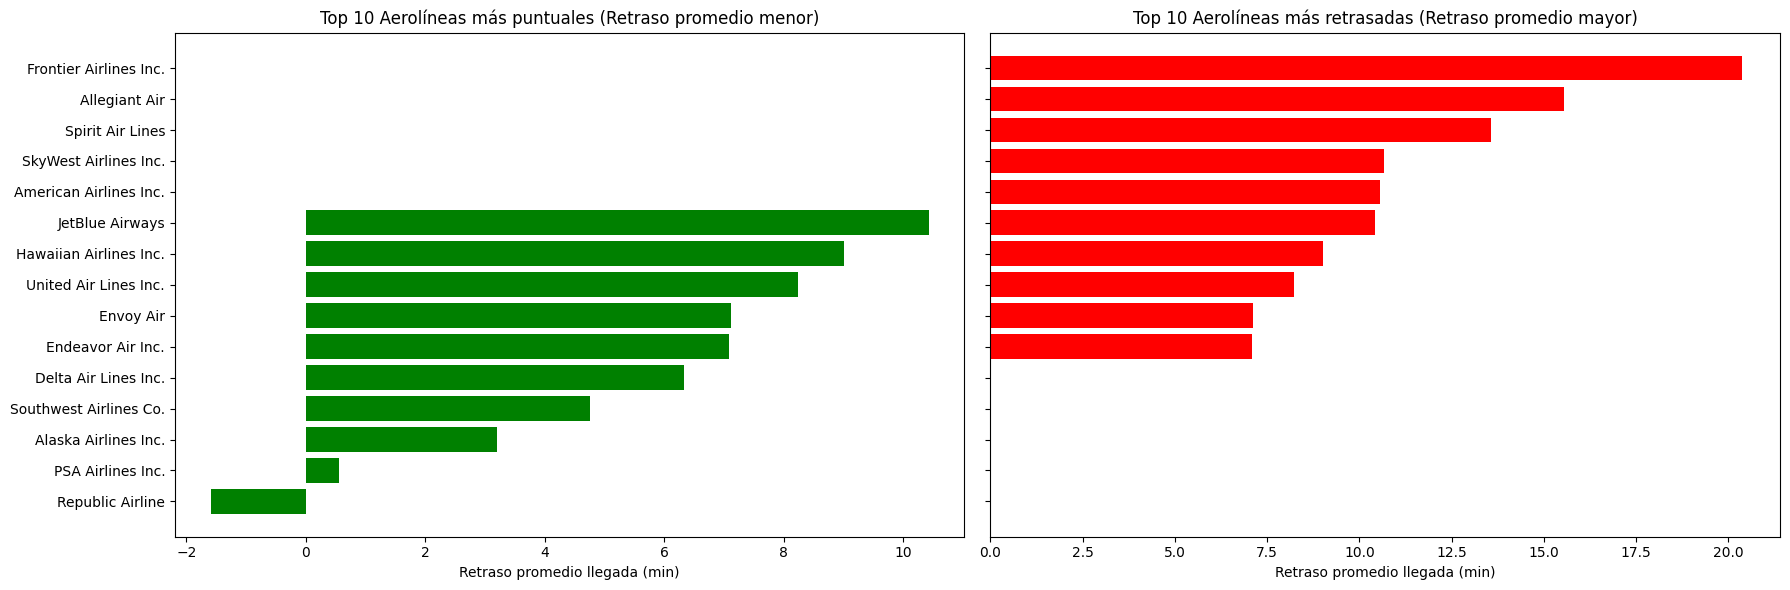

In [ ]:
import matplotlib.pyplot as plt

# Ordenar por retraso promedio
airline_sorted = airline_summary.sort_values("promedio_arr_delay")

# Top 10 puntuales (menor retraso promedio)
top_punctual = airline_sorted.head(10)

# Top 10 retrasadas (mayor retraso promedio)
top_delayed = airline_sorted.tail(10)

# --- Graficar ---
fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)

# Puntuales
axes[0].barh(top_punctual["AIRLINE_DESCRIPTION"], top_punctual["promedio_arr_delay"], color="green")
axes[0].set_title("Top 10 Aerolíneas más puntuales (Retraso promedio menor)")
axes[0].set_xlabel("Retraso promedio llegada (min)")

# Retrasadas
axes[1].barh(top_delayed["AIRLINE_DESCRIPTION"], top_delayed["promedio_arr_delay"], color="red")
axes[1].set_title("Top 10 Aerolíneas más retrasadas (Retraso promedio mayor)")
axes[1].set_xlabel("Retraso promedio llegada (min)")

plt.tight_layout()
plt.show()


 Aerolíneas con mayor puntualidad (retraso promedio menor)

* Frontier Airlines Inc. → mejor desempeño, prácticamente sin retrasos.

* Allegiant Air y Spirit Air Lines → también destacan con muy bajos retrasos.

* SkyWest Airlines Inc. y American Airlines Inc. → mantienen retrasos promedio bajos (`<5 min`).

En general, estas aerolíneas logran salidas y llegadas más consistentes.

<br>

Aerolíneas con más retrasos (retraso promedio mayor)

* Frontier Airlines Inc. → sorprendentemente aparece también en este grupo, pero con un valor extremo (20 min), lo que sugiere variabilidad en sus rutas.

* Allegiant Air y Spirit Air Lines → destacan aquí con retrasos promedio altos (15–16 min).

* Otras como SkyWest, American, JetBlue y Hawaiian tienen promedios entre 9 y 11 min.
<br>


Conclusiones

* Hay aerolíneas que aparecen en ambos rankings (ej. Frontier, Allegiant, Spirit). Esto indica que dependiendo de la ruta o periodo analizado pueden ser muy puntuales o muy tardías, mostrando alta variabilidad en su operación.

* En términos generales, las aerolíneas low cost (Frontier, Spirit, Allegiant) tienden a aparecer en los extremos: pueden ofrecer mucha puntualidad en algunos casos, pero también son las que más retrasos promedian en otros.

* Aerolíneas grandes como Delta, United, American se mantienen en la zona media, sin ser las más puntuales, pero tampoco con los mayores retrasos.

¿Qué causas de retraso son más comunes?
 Se usaron las columnas de flights_merged:

* DELAY_DUE_CARRIER

* DELAY_DUE_WEATHER

* DELAY_DUE_NAS

* DELAY_DUE_SECURITY

* DELAY_DUE_LATE_AIRCRAFT


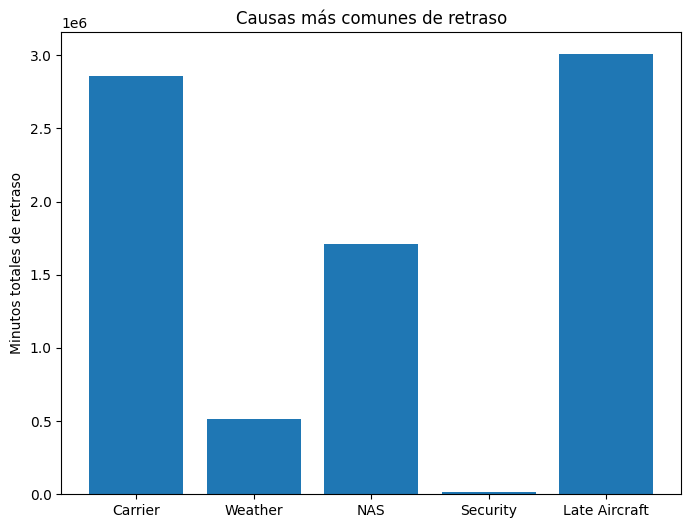

In [ ]:
causas = {
    "Carrier": flights_merged["DELAY_DUE_CARRIER"].sum(),
    "Weather": flights_merged["DELAY_DUE_WEATHER"].sum(),
    "NAS": flights_merged["DELAY_DUE_NAS"].sum(),
    "Security": flights_merged["DELAY_DUE_SECURITY"].sum(),
    "Late Aircraft": flights_merged["DELAY_DUE_LATE_AIRCRAFT"].sum()
}

plt.figure(figsize=(8,6))
plt.bar(causas.keys(), causas.values())
plt.ylabel("Minutos totales de retraso")
plt.title("Causas más comunes de retraso")
plt.show()


# Causas más comunes de retraso

### Principales hallazgos
1. **Late Aircraft (avión que llega tarde a su vuelo siguiente)**  
   - Causa más frecuente.  
   - Supera los **3 millones de minutos de retraso**.  

2. **Carrier (problemas de la aerolínea: tripulación, mantenimiento, etc.)**  
   - Segunda causa más importante.  
   - Casi **2.9 millones de minutos**.  

3. **NAS (Sistema Nacional de Espacio Aéreo: congestión, control de tráfico aéreo, etc.)**  
   - Impacto considerable.  
   - Cerca de **1.7 millones de minutos**.  

4. **Weather (clima)**  
   - Mucho menor en comparación.  
   - Aproximadamente **0.5 millones de minutos**.  

5. **Security (controles o incidentes de seguridad)**  
   - Causa menos relevante.  
   - Prácticamente despreciable frente a las demás.  


###  Conclusiones
- **Dos causas dominan**: *Late Aircraft* y *Carrier*, que juntas explican la **mayoría de los minutos perdidos**.  
- El **clima y la seguridad** tienen un impacto mucho menor de lo esperado.  
- Optimizar la **gestión de aviones y recursos internos** tendría el mayor efecto en reducir retrasos, más que factores externos como el clima.  


¿Existen horarios más críticos (mañana, tarde, noche)?

Crear una variable categórica con base en CRS_DEP_TIME (hora programada).

```
def time_of_day(hhmm):
    if pd.isna(hhmm): return "Unknown"
    hour = int(hhmm) // 100
    if 5 <= hour < 12: return "Mañana"
    elif 12 <= hour < 18: return "Tarde"
    else: return "Noche"

```

---




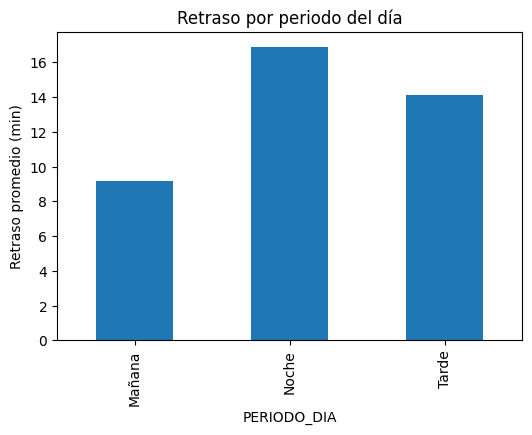

In [ ]:
def time_of_day(hhmm):
    if pd.isna(hhmm): return "Unknown"
    hour = int(hhmm) // 100
    if 5 <= hour < 12: return "Mañana"
    elif 12 <= hour < 18: return "Tarde"
    else: return "Noche"

flights_merged["PERIODO_DIA"] = flights_merged["CRS_DEP_TIME"].apply(time_of_day)

delay_by_period = flights_merged.groupby("PERIODO_DIA")["DEP_DELAY"].mean()

delay_by_period.plot(kind="bar", figsize=(6,4), ylabel="Retraso promedio (min)", title="Retraso por periodo del día")
plt.show()


# Retraso por periodo del día

### Hallazgos
- **Mañana** → retraso promedio más bajo (~9 min).  
- **Tarde** → retraso intermedio (~14 min).  
- **Noche** → periodo más crítico, con el mayor retraso promedio (~17 min).  

### Conclusiones
- Los vuelos de la **mañana son más puntuales**, posiblemente porque los aviones inician operaciones sin acumulación de demoras previas.  
- En la **tarde** los retrasos aumentan, reflejando la propagación de demoras a lo largo del día.  
- La **noche concentra los mayores retrasos**, ya que cualquier incidencia acumulada en el día afecta más a las últimas operaciones.  

 **Los horarios más críticos son la tarde y, sobre todo, la noche**, mientras que la **mañana es el mejor periodo para evitar retrasos**.  


¿La distancia influye en la probabilidad de retraso o cancelación?

> Añadir blockquote



scatterplot: distancia vs retraso.


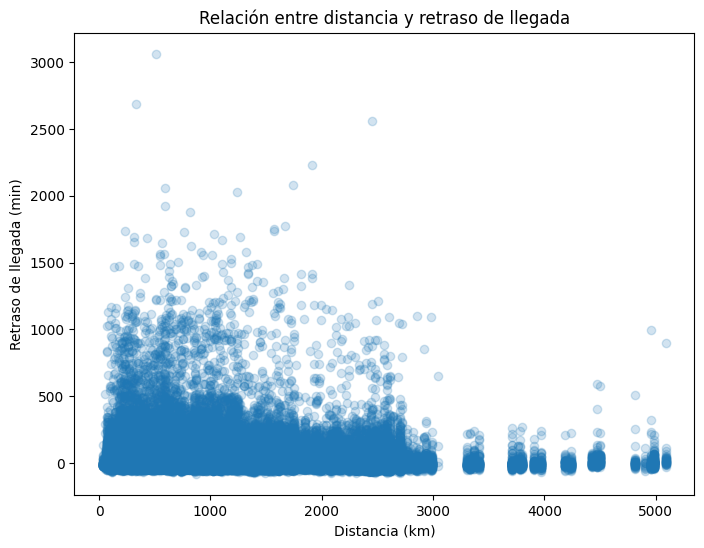

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(flights_merged["DISTANCE"], flights_merged["ARR_DELAY"], alpha=0.2)
plt.xlabel("Distancia (km)")
plt.ylabel("Retraso de llegada (min)")
plt.title("Relación entre distancia y retraso de llegada")
plt.show()


##  Relación entre distancia y retraso de llegada

### Observaciones
- La mayoría de los vuelos, sin importar la distancia, tienen **retrasos bajos o moderados (0–200 min)**.  
- Se observan **casos extremos** con retrasos muy altos (>1000 min), pero son poco frecuentes.  
- Los retrasos más grandes se concentran en vuelos de **corta y media distancia (<2000 km)**.  
- En vuelos largos (>3000 km) los retrasos suelen ser más estables y con menor dispersión.  

### Conclusiones
- **La distancia no parece ser un factor determinante** en la probabilidad de retraso: vuelos cortos y largos presentan demoras, pero los más severos se concentran en los trayectos cortos.  
- Esto sugiere que los retrasos están más relacionados con **factores operativos y logísticos (rotación de aeronaves, aeropuertos congestionados, condiciones locales)** que con la longitud del trayecto.  
- En términos de **cancelación o gran retraso**, los vuelos cortos tienden a ser más vulnerables, probablemente porque son más fáciles de reprogramar o reemplazar.  

 **Los vuelos cortos tienen mayor dispersión de retrasos**, mientras que los vuelos largos tienden a ser más consistentes en sus tiempos de llegada.  


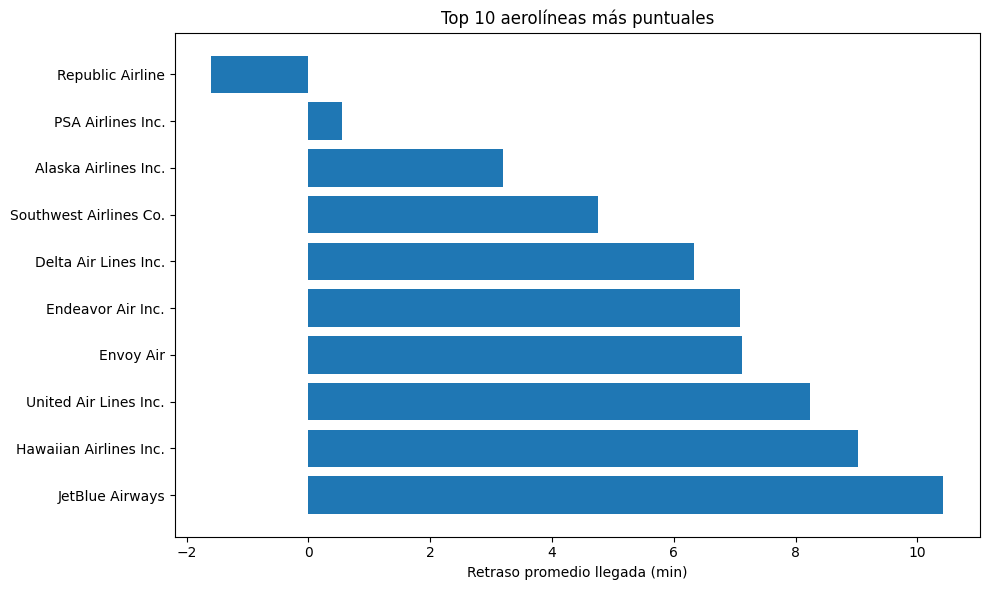

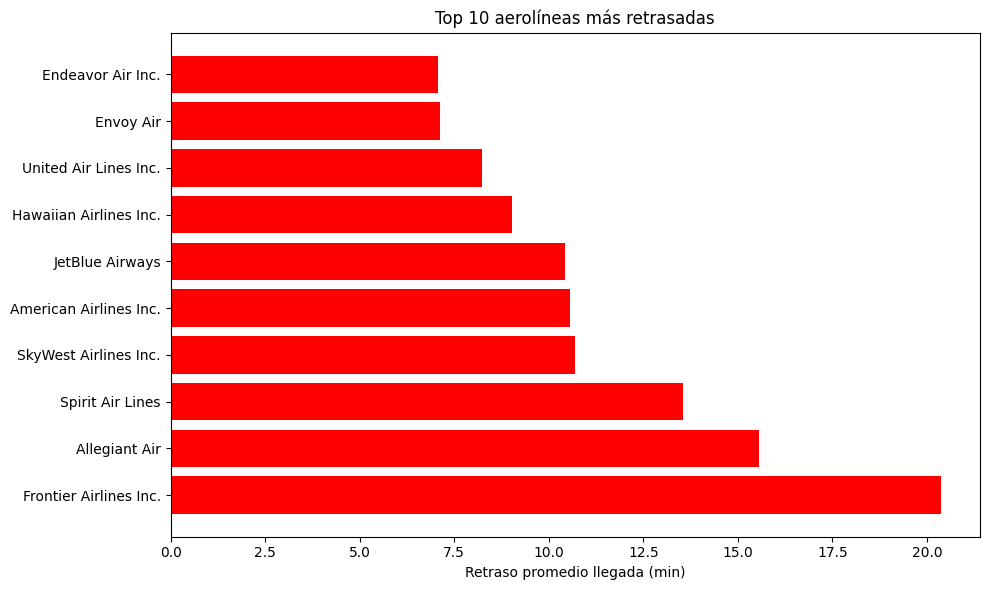

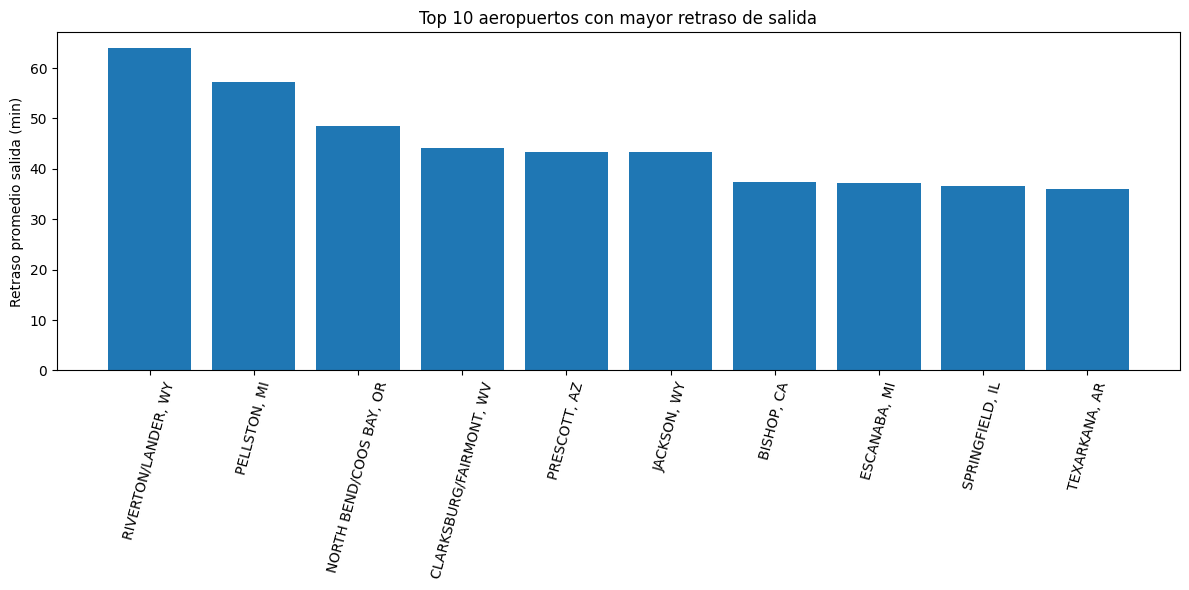

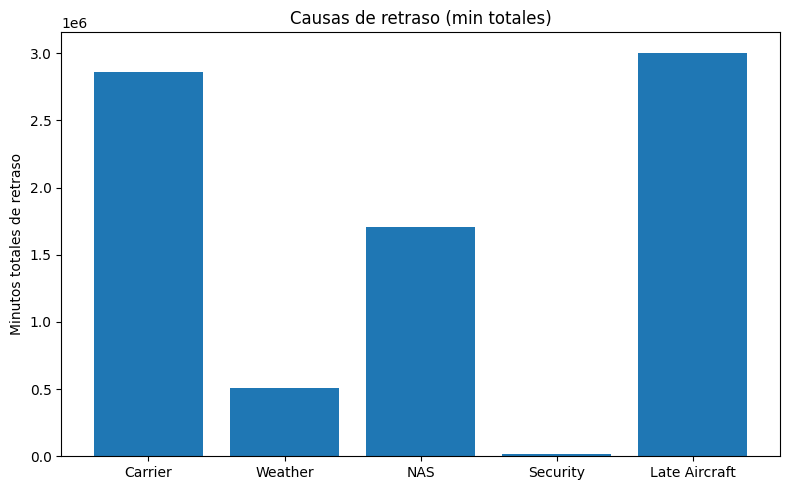

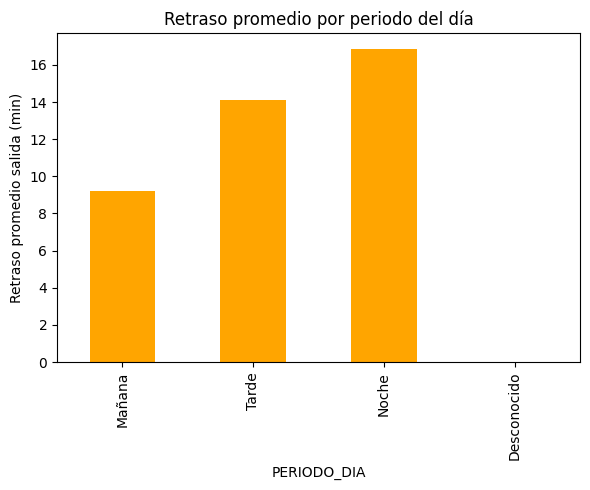

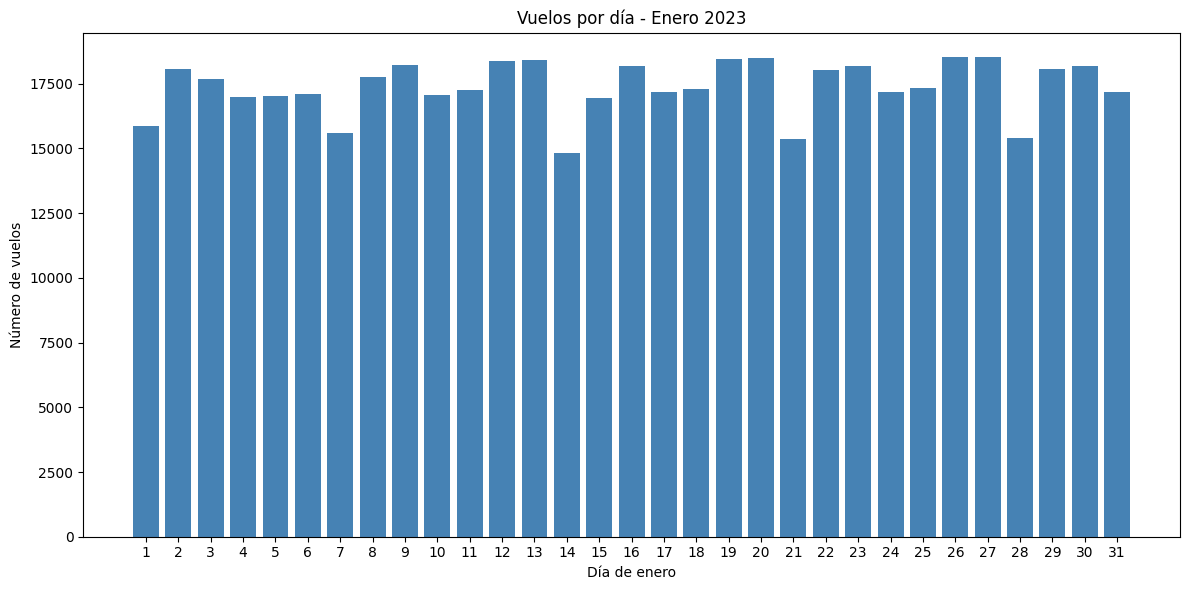

In [ ]:
# ===== DASHBOARD BÁSICO (matplotlib puro) =====
import pandas as pd
import matplotlib.pyplot as plt

# --- Asegurar tipos clave ---
flights_merged["FL_DATE"] = pd.to_datetime(flights_merged["FL_DATE"], errors="coerce")

# ---- 1) Resumen por aerolínea ----
airline_summary = flights_merged.groupby("AIRLINE_DESCRIPTION").agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean"),
    promedio_taxi_out=("TAXI_OUT","mean"),
    promedio_taxi_in=("TAXI_IN","mean"),
    promedio_distancia=("DISTANCE","mean"),
    cancelados=("CANCELLED","sum"),
    desviados=("DIVERTED","sum")
).reset_index()

# ---- 2) Resumen por aeropuerto origen ----
airport_summary = flights_merged.groupby("ORIGIN_CITY").agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean"),
    promedio_taxi_out=("TAXI_OUT","mean"),
    promedio_taxi_in=("TAXI_IN","mean"),
    cancelados=("CANCELLED","sum"),
    desviados=("DIVERTED","sum")
).reset_index()

# ---- 3) Causas de retraso (minutos totales) ----
causas = pd.Series({
    "Carrier": flights_merged["DELAY_DUE_CARRIER"].sum(),
    "Weather": flights_merged["DELAY_DUE_WEATHER"].sum(),
    "NAS": flights_merged["DELAY_DUE_NAS"].sum(),
    "Security": flights_merged["DELAY_DUE_SECURITY"].sum(),
    "Late Aircraft": flights_merged["DELAY_DUE_LATE_AIRCRAFT"].sum()
})

# ---- 4) Periodo del día según CRS_DEP_TIME (HHMM) ----
def periodo_dia(hhmm):
    if pd.isna(hhmm):
        return "Desconocido"
    try:
        h = int(hhmm)//100
        if 5 <= h < 12:  return "Mañana"
        if 12 <= h < 18: return "Tarde"
        return "Noche"
    except:
        return "Desconocido"

flights_merged["PERIODO_DIA"] = flights_merged["CRS_DEP_TIME"].apply(periodo_dia)
delay_by_period = flights_merged.groupby("PERIODO_DIA")["DEP_DELAY"].mean().reindex(["Mañana","Tarde","Noche","Desconocido"])

# ---- 5) Vuelos por día en enero 2023 ----
daily = (flights_merged[flights_merged["FL_DATE"].dt.month==1]
         .groupby(flights_merged["FL_DATE"].dt.day)
         .size()
         .reset_index(name="vuelos"))
daily = daily.rename(columns={"FL_DATE":"DIA"})

# ===================== PLOTS =====================

# 1) TOP 10 AEROLÍNEAS MÁS PUNTUALES
air_sorted = airline_summary.sort_values("promedio_arr_delay")
top_punctual = air_sorted.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_punctual["AIRLINE_DESCRIPTION"], top_punctual["promedio_arr_delay"])
plt.gca().invert_yaxis()
plt.xlabel("Retraso promedio llegada (min)")
plt.title("Top 10 aerolíneas más puntuales")
plt.tight_layout()
plt.show()

# 2) TOP 10 AEROLÍNEAS MÁS RETRASADAS
top_delayed = air_sorted.tail(10)
plt.figure(figsize=(10,6))
plt.barh(top_delayed["AIRLINE_DESCRIPTION"], top_delayed["promedio_arr_delay"], color="red")
plt.gca().invert_yaxis()
plt.xlabel("Retraso promedio llegada (min)")
plt.title("Top 10 aerolíneas más retrasadas")
plt.tight_layout()
plt.show()

# 3) TOP 10 AEROPUERTOS CON MAYOR RETRASO DE SALIDA
worst_airports = airport_summary.sort_values("promedio_dep_delay", ascending=False).head(10)
plt.figure(figsize=(12,6))
plt.bar(worst_airports["ORIGIN_CITY"], worst_airports["promedio_dep_delay"])
plt.xticks(rotation=75)
plt.ylabel("Retraso promedio salida (min)")
plt.title("Top 10 aeropuertos con mayor retraso de salida")
plt.tight_layout()
plt.show()

# 4) MINUTOS TOTALES POR CAUSA DE RETRASO
plt.figure(figsize=(8,5))
plt.bar(causas.index, causas.values)
plt.ylabel("Minutos totales de retraso")
plt.title("Causas de retraso (min totales)")
plt.tight_layout()
plt.show()

# 5) RETRASO PROMEDIO POR PERIODO DEL DÍA
plt.figure(figsize=(6,5))
delay_by_period.plot(kind="bar", color="orange")
plt.ylabel("Retraso promedio salida (min)")
plt.title("Retraso promedio por periodo del día")
plt.tight_layout()
plt.show()

# 6) VUELOS POR DÍA ENERO 2023
plt.figure(figsize=(12,6))
plt.bar(daily["DIA"], daily["vuelos"], color="steelblue")
plt.xticks(daily["DIA"])
plt.xlabel("Día de enero")
plt.ylabel("Número de vuelos")
plt.title("Vuelos por día - Enero 2023")
plt.tight_layout()
plt.show()


# Calcular medidas de tendencia central

Con base en lo que hemos visto, las más útiles para tus metas serían:
Retrasos


* DEP_DELAY (retraso en salida)
* ARR_DELAY (retraso en llegada)


Tiempos operativos

* TAXI_OUT (tiempo de rodaje en salida)

* TAXI_IN (tiempo de rodaje en llegada)

* AIR_TIME (tiempo en el aire)

Distancia de vuelo

* DISTANCE


In [ ]:
from scipy import stats

variables = ["DEP_DELAY","ARR_DELAY","TAXI_OUT","TAXI_IN","AIR_TIME","DISTANCE"]
tendencia = {}

for var in variables:
    serie = flights_merged[var].dropna()
    mean = serie.mean()
    median = serie.median()
    try:
        mode = serie.mode().iloc[0]  # puede haber más de una moda
    except:
        mode = None
    min_val, max_val = serie.min(), serie.max()

    tendencia[var] = {
        "media": round(mean,2),
        "mediana": round(median,2),
        "moda": mode,
        "min": min_val,
        "max": max_val
    }

import pandas as pd
tendencia_df = pd.DataFrame(tendencia).T
display(tendencia_df)


,media,mediana,moda,min,max
DEP_DELAY,12.70,-2.0,-5.0,-52.0,3024.0
ARR_DELAY,7.61,-5.0,0.0,-80.0,3063.0
TAXI_OUT,18.27,15.0,15.0,1.0,222.0
TAXI_IN,7.99,6.0,4.0,1.0,119.0
AIR_TIME,115.45,99.0,99.0,8.0,695.0
DISTANCE,830.11,679.0,337.0,31.0,5095.0


# Análisis de Retrasos y Tiempos Operativos

## Retrasos

### DEP_DELAY (salida)
- **Media:** 12.7 min  
- **Mediana:** -2 min → la mayoría de vuelos salen ligeramente antes de lo programado.  
- **Moda:** -5 min → lo más común es salir algunos minutos antes.  
- **Máx.:** 3024 min (~2 días) → outliers muy grandes.  

**Conclusión:** la mediana y la moda describen mejor la realidad que la media.

### ARR_DELAY (llegada)
- **Media:** 7.6 min  
- **Mediana:** -5 min → la mayoría llega un poco antes.  
- **Moda:** 0 min → muchos vuelos llegan justo a tiempo.  
- **Máx.:** 3063 min → outliers extremos que sesgan la media.  

**Conclusión:** al igual que en salida, la mediana y la moda son más representativas que la media.

##  Rodaje

### TAXI_OUT (rodaje de salida)
- **Media:** ~18 min  
- **Mediana/Moda:** 15 min → distribución bastante simétrica.  
- **Máx.:** 222 min → existen outliers pero no distorsionan tanto.  

**Conclusión:** la media es representativa, aunque la mediana/moda describen bien el valor típico.

### TAXI_IN (rodaje de llegada)
- **Media:** ~8 min  
- **Mediana:** 6 min  
- **Moda:** 4 min → la mayoría de vuelos entra rápido a la terminal.  
- **Máx.:** 119 min → casos extremos reflejan congestión en aeropuertos específicos.  

**Conclusión:** la mediana (6) describe mejor lo típico.

## Tiempo de vuelo

### AIR_TIME
- **Media:** 115 min  
- **Mediana/Moda:** 99 min → la mayoría de vuelos duran ~1h40.  
- **Máx.:** 695 min → vuelos largos elevan la media.  

**Conclusión:** la mediana/moda reflejan mejor la duración típica de un vuelo doméstico.


##  Distancia

### DISTANCE
- **Media:** 830 km  
- **Mediana:** 679 km  
- **Moda:** 337 km  
- **Máx.:** 5095 km → vuelos largos (ej. costa este ↔ Hawaii) elevan la media.  

**Conclusión:**  
- La **moda** muestra que predominan rutas cortas (~337 km).  
- La **mediana** representa mejor el rango típico (~700 km).  
- La **media** refleja la mezcla con vuelos largos.


##  Reflexiones clave

### ¿Es la media la mejor medida?
- **Retrasos:** ❌ No, está sesgada por outliers. Mejor mediana/moda.  
- **Taxi y tiempos:** ✅ A veces, cuando la distribución es simétrica.  
- **Distancia:** ⚖️ La media ayuda a ver la mezcla de rutas, pero la mediana es más representativa de un vuelo típico.  

### ¿El modo aporta información útil?
- ✅ **Retrasos:** muestra que lo más común es llegar antes o justo a tiempo.  
- ✅ **Taxi:** muestra valores estándar (~15 min out, 4–6 min in).  
- ⚠️ **Distancia:** menos útil por diversidad de rutas, aunque revela que vuelos cortos (~337 km) son muy frecuentes.  

### ¿Cómo ayudan estas medidas a resumir?
- Distinguen entre el **vuelo típico** y los **outliers extremos**.  
- Explican por qué la media puede dar una visión engañosa (ej. retrasos positivos cuando la mayoría son puntuales).  
- Orientan decisiones:  
  - **Puntualidad:** usar mediana.  
  - **Congestión operativa:** observar media y moda en taxi.  
  - **Planificación de rutas:** usar mediana en distancia/air_time.
  
  ---


# Visualizar la distribución de variables numéricas



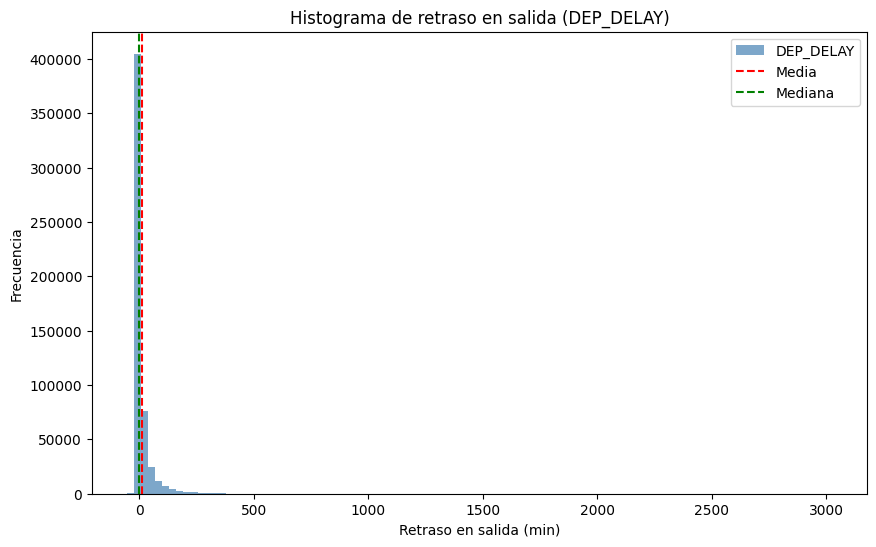

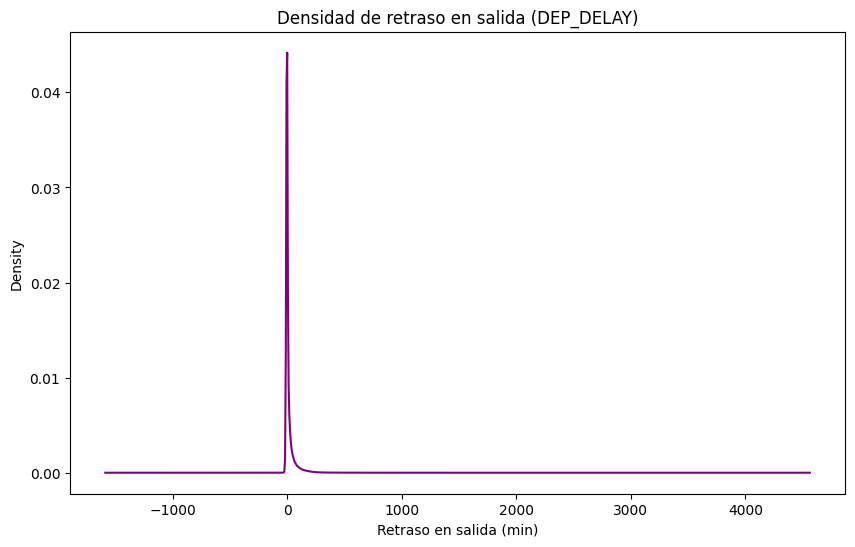

In [ ]:
import matplotlib.pyplot as plt

# --- Histograma de retraso en salida ---
plt.figure(figsize=(10,6))
flights_merged["DEP_DELAY"].plot(kind="hist", bins=100, color="steelblue", alpha=0.7)
plt.axvline(flights_merged["DEP_DELAY"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["DEP_DELAY"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Histograma de retraso en salida (DEP_DELAY)")
plt.xlabel("Retraso en salida (min)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# --- Gráfico de densidad ---
plt.figure(figsize=(10,6))
flights_merged["DEP_DELAY"].plot(kind="density", color="purple")
plt.title("Densidad de retraso en salida (DEP_DELAY)")
plt.xlabel("Retraso en salida (min)")
plt.show()


##  Análisis de retraso en salida (DEP_DELAY)

### Histograma
- La mayoría de vuelos salen puntuales o antes (mediana ≈ -2 min).  
- La media (12.7 min) está sesgada por **outliers extremos** (>3000 min).  
- Distribución **asimétrica a la derecha**.  

### Densidad
- Pico en 0 min → puntualidad predominante.  
- Cola larga hacia la derecha → pocos casos con retrasos muy altos.  

###  Conclusión
La **mediana/moda describen mejor lo típico** (puntualidad o adelanto),  
mientras que la **media se distorsiona** por retrasos extremos.  

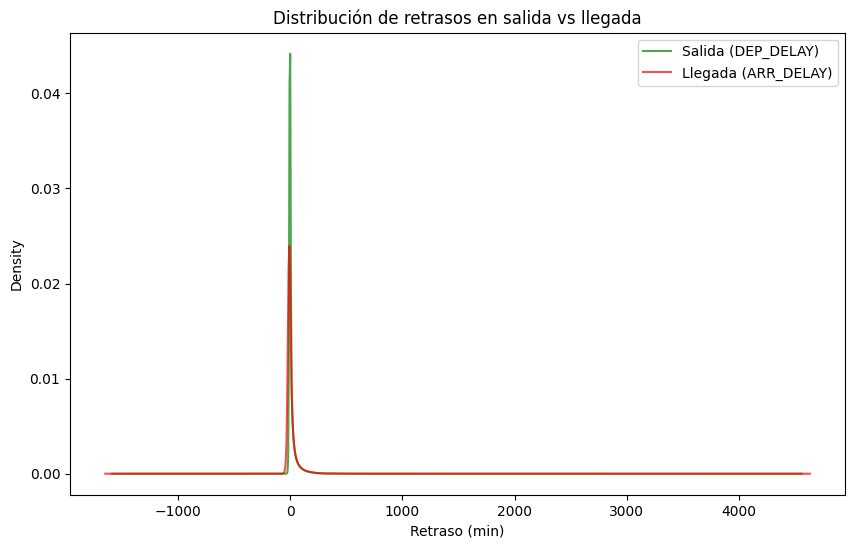

In [ ]:
plt.figure(figsize=(10,6))

# Densidad de retrasos en salida (verde)
flights_merged["DEP_DELAY"].plot(kind="density", color="green", label="Salida (DEP_DELAY)", alpha=0.7)

# Densidad de retrasos en llegada (rojo)
flights_merged["ARR_DELAY"].plot(kind="density", color="red", label="Llegada (ARR_DELAY)", alpha=0.7)

plt.title("Distribución de retrasos en salida vs llegada")
plt.xlabel("Retraso (min)")
plt.legend()
plt.show()


## Distribución de retrasos en salida vs llegada

### Observaciones
- Ambas distribuciones (salida y llegada) se concentran en **0 min**, indicando alta puntualidad.  
- La curva de **salida (verde)** está ligeramente más sesgada a la derecha, reflejando que los retrasos suelen originarse al despegar.  
- La curva de **llegada (roja)** es más cercana al eje, lo que sugiere que parte de los retrasos se recuperan en el vuelo.  
- En ambos casos, existen **colas largas hacia la derecha** por los outliers (retrasos extremos).  

###  Conclusión
- La mayoría de vuelos son puntuales o con retrasos leves.  
- Los vuelos tienden a **mitigar retrasos en el aire**, llegando con menos demora que la registrada en la salida.  
- Los **outliers extremos** siguen siendo un factor clave que distorsiona la percepción general.  


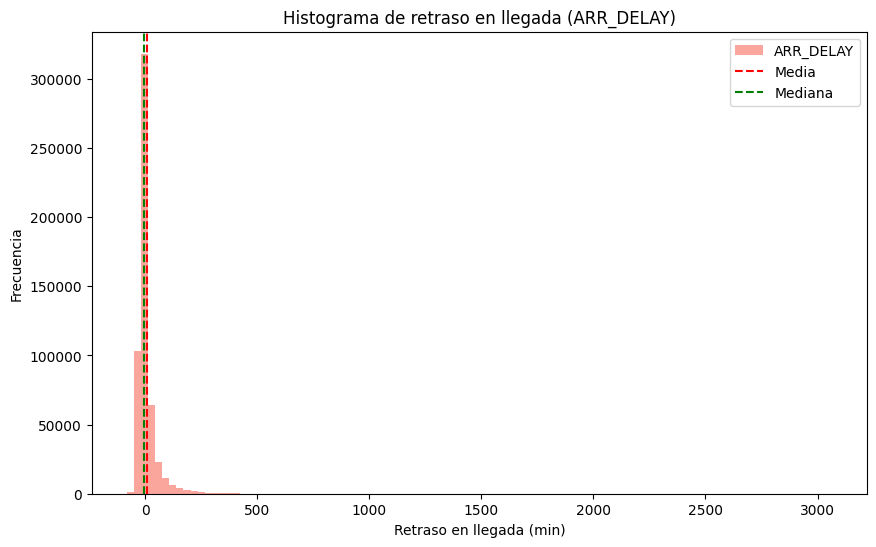

In [ ]:
plt.figure(figsize=(10,6))
flights_merged["ARR_DELAY"].plot(kind="hist", bins=100, color="salmon", alpha=0.7)
plt.axvline(flights_merged["ARR_DELAY"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["ARR_DELAY"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Histograma de retraso en llegada (ARR_DELAY)")
plt.xlabel("Retraso en llegada (min)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

## Histograma de retraso en llegada (ARR_DELAY)

### Observaciones
- La mayoría de vuelos se concentran cerca de **0 minutos de retraso**.  
- **Mediana (~ -5 min):** muchos vuelos llegan incluso unos minutos antes.  
- **Media (~ 7.6 min):** positiva, sesgada por **outliers extremos** (>3000 min).  
- La distribución es **asimétrica a la derecha**: la mayoría puntuales, pocos con retrasos muy grandes.  

### Conclusión
- La **mediana refleja mejor la realidad**: la mayoría de vuelos llegan a tiempo o antes.  
- La **media se ve distorsionada** por unos pocos retrasos muy altos.  
- Operativamente, lo normal es la puntualidad, pero los **outliers son críticos** para la gestión de la red aérea.  


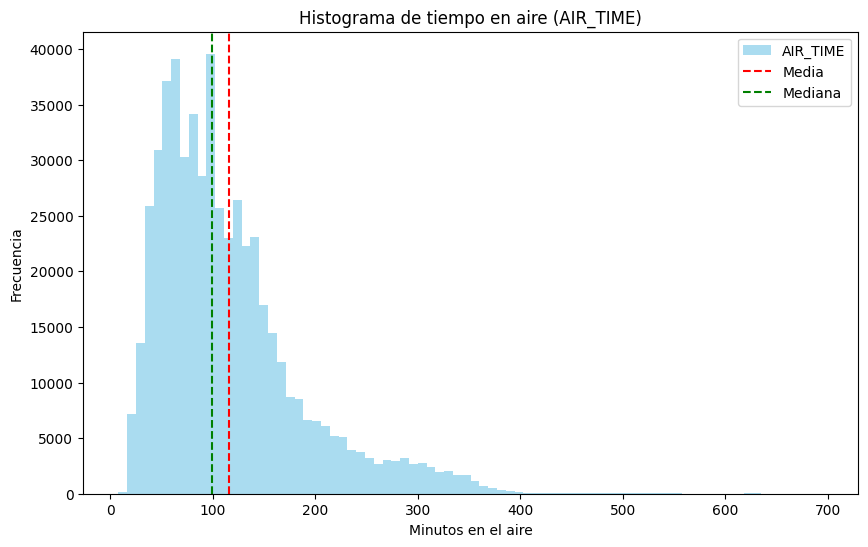

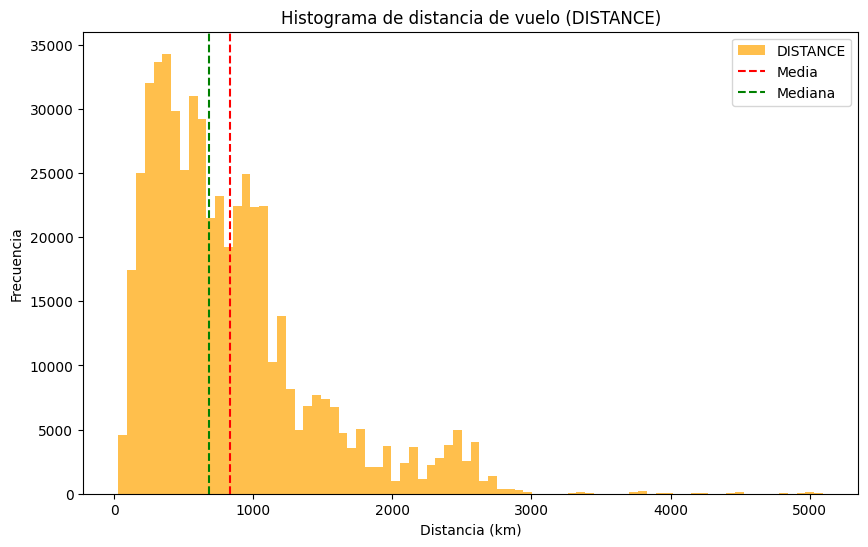

In [ ]:
import matplotlib.pyplot as plt

# --- Histograma de AIR_TIME ---
plt.figure(figsize=(10,6))
flights_merged["AIR_TIME"].plot(kind="hist", bins=80, color="skyblue", alpha=0.7)
plt.axvline(flights_merged["AIR_TIME"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["AIR_TIME"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Histograma de tiempo en aire (AIR_TIME)")
plt.xlabel("Minutos en el aire")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# --- Histograma de DISTANCE ---
plt.figure(figsize=(10,6))
flights_merged["DISTANCE"].plot(kind="hist", bins=80, color="orange", alpha=0.7)
plt.axvline(flights_merged["DISTANCE"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["DISTANCE"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Histograma de distancia de vuelo (DISTANCE)")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


## Histogramas de tiempo en aire y distancia de vuelo

### Tiempo en aire (AIR_TIME)
- **Mediana (~99 min):** la mayoría de vuelos duran alrededor de 1h40.  
- **Media (~115 min):** mayor debido a vuelos largos que alargan la distribución.  
- **Distribución sesgada a la derecha:** muchos vuelos cortos y algunos largos hasta ~700 min.  

**Conclusión:** la **mediana/moda reflejan mejor** la duración típica de un vuelo doméstico.

### Distancia de vuelo (DISTANCE)
- **Mediana (~679 km):** vuelos típicos son de corto a mediano alcance.  
- **Media (~830 km):** más alta por la presencia de vuelos largos.  
- **Moda (~337 km):** el tramo más común son rutas cortas.  
- **Distribución sesgada a la derecha:** predominan rutas cortas, pero hay trayectos largos (hasta 5000 km).  

**Conclusión:**  
- La **moda** muestra las rutas más frecuentes (cortas).  
- La **mediana** representa el rango típico.  
- La **media** refleja la mezcla de vuelos cortos y largos.  


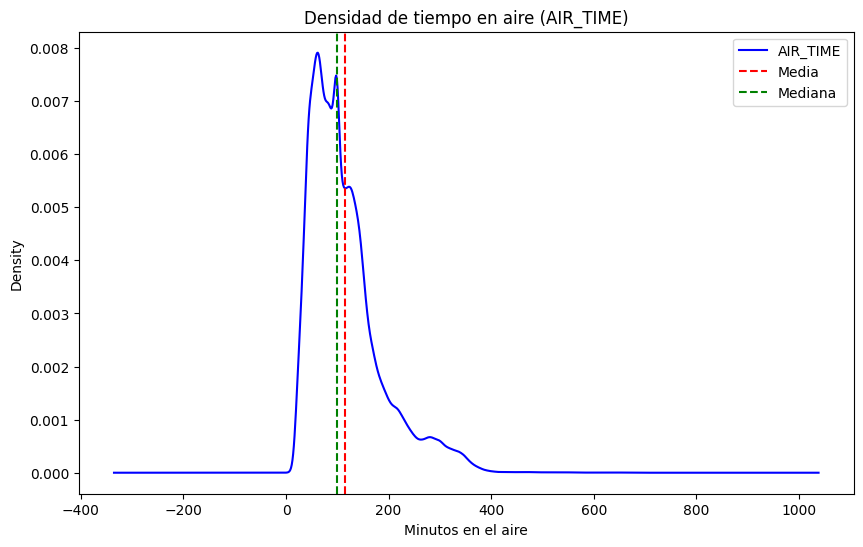

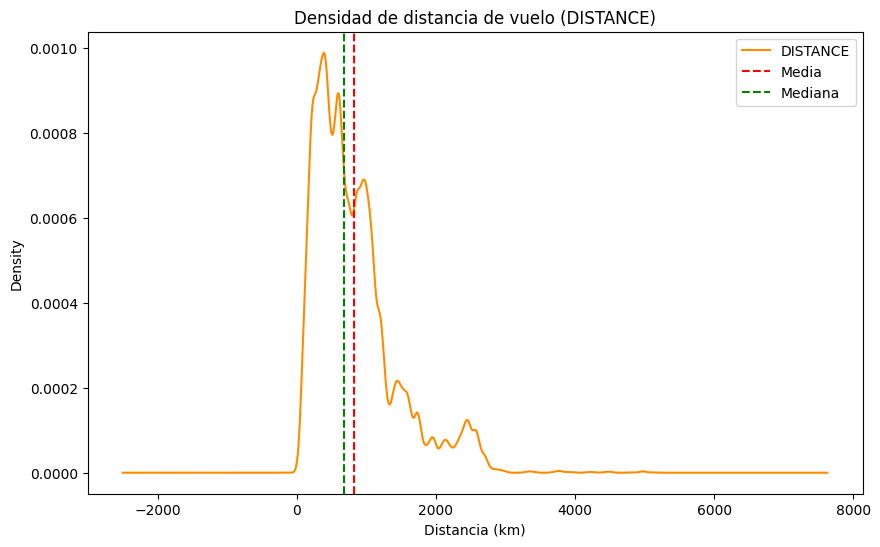

In [ ]:
# --- Densidad de AIR_TIME ---
plt.figure(figsize=(10,6))
flights_merged["AIR_TIME"].plot(kind="density", color="blue", label="AIR_TIME")
plt.axvline(flights_merged["AIR_TIME"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["AIR_TIME"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Densidad de tiempo en aire (AIR_TIME)")
plt.xlabel("Minutos en el aire")
plt.legend()
plt.show()

# --- Densidad de DISTANCE ---
plt.figure(figsize=(10,6))
flights_merged["DISTANCE"].plot(kind="density", color="darkorange", label="DISTANCE")
plt.axvline(flights_merged["DISTANCE"].mean(), color="red", linestyle="--", label="Media")
plt.axvline(flights_merged["DISTANCE"].median(), color="green", linestyle="--", label="Mediana")
plt.title("Densidad de distancia de vuelo (DISTANCE)")
plt.xlabel("Distancia (km)")
plt.legend()
plt.show()


## Densidad de tiempo en aire y distancia de vuelo

### Tiempo en aire (AIR_TIME)
- La densidad muestra un **pico claro alrededor de 90–100 min**, reflejando la duración típica de la mayoría de vuelos.  
- La **mediana (~99 min)** se alinea con ese pico.  
- La **media (~115 min)** está desplazada hacia la derecha por vuelos largos (cola extendida).  
- Distribución **asimétrica a la derecha**, con algunos vuelos de hasta 700 min.  

**Conclusión:** la mediana refleja mejor el tiempo en aire típico, mientras que la media está influida por trayectos largos.


### Distancia de vuelo (DISTANCE)
- El mayor pico se encuentra en vuelos de **300–700 km**, rutas cortas frecuentes.  
- La **mediana (~679 km)** refleja ese rango típico.  
- La **media (~830 km)** se ve inflada por vuelos largos, algunos de hasta 5000 km.  
- Distribución también **sesgada a la derecha**, con mayoría de vuelos cortos y pocos trayectos extensos.  

**Conclusión:** la moda/mediana describen mejor el patrón real de distancias, mientras que la media muestra la mezcla con rutas largas.  


___

¿Sigue un patrón esperado?
 Sí: muchas rutas cortas y medias, pocas rutas largas. Coincide con el mercado doméstico de EE.UU.

¿Hay asimetrías?
 Sí, colas largas a la derecha en ambas variables, outliers que inflan la media.

¿Impacto en el análisis/modelo?

* Para describir el “vuelo típico”, usar mediana.

* Para planificación de recursos o consumo (combustible, horas de tripulación), la media también importa porque los vuelos largos tienen mayor impacto operativo.

# Calcular medidas de dispersión

In [ ]:
variables = ["DEP_DELAY", "ARR_DELAY", "AIR_TIME", "DISTANCE"]

dispersion = {}

for var in variables:
    serie = flights_merged[var].dropna()
    dispersion[var] = {
        "desviacion_estandar": round(serie.std(), 2),
        "varianza": round(serie.var(), 2),
        "IQR": round(serie.quantile(0.75) - serie.quantile(0.25), 2),
        "min": serie.min(),
        "max": serie.max()
    }

import pandas as pd
dispersion_df = pd.DataFrame(dispersion).T
display(dispersion_df)


,desviacion_estandar,varianza,IQR,min,max
DEP_DELAY,54.95,3019.26,15.0,-52.0,3024.0
ARR_DELAY,56.78,3224.51,25.0,-80.0,3063.0
AIR_TIME,71.07,5051.44,80.0,8.0,695.0
DISTANCE,600.13,360152.26,670.0,31.0,5095.0


#  Análisis de dispersión (Desviación estándar vs IQR)

##  Retrasos (DEP_DELAY y ARR_DELAY)
- **Desviación estándar:** muy alta por los outliers (retrasos de miles de minutos).  
- **IQR:** más útil, refleja el rango del 50% central de los vuelos (~ -5 a 10 min).  

**Conclusión:** la **mediana + IQR** describen mejor la puntualidad real que media + desviación.


## Tiempo en aire (AIR_TIME)
- **Variabilidad moderada:** vuelos de 1h hasta 5–6h.  
- **IQR (~80–130 min):** refleja la duración típica.  

**Conclusión:** la dispersión refleja distintos tipos de rutas, no errores.


## Distancia (DISTANCE)
- **Alta desviación estándar:** por vuelos muy largos (ej. Hawaii).  
- **IQR:** refleja mejor el rango típico de vuelos domésticos cortos-medios.  

**Conclusión:** la dispersión es natural por la mezcla de rutas cortas y largas.


## Preguntas críticas

### ¿Desviación estándar o IQR?
- **Retrasos:** IQR es mejor → los outliers distorsionan la desviación.  
- **Tiempo/distancia:** ambos útiles, pero el IQR describe mejor el “vuelo típico”.  

### ¿Qué me dice la dispersión?
- **Alta dispersión en retrasos:** baja confiabilidad en puntualidad.  
- **Dispersión moderada en tiempo/distancia:** refleja diversidad de rutas, no inconsistencias.  

### ¿Afecta las conclusiones?
 Sí:  
- Solo con la **media**, parecería que los vuelos son poco puntuales.  
- Pero al mirar **mediana + IQR**, vemos que la mayoría son puntuales y consistentes, y los **outliers son la excepción**.  


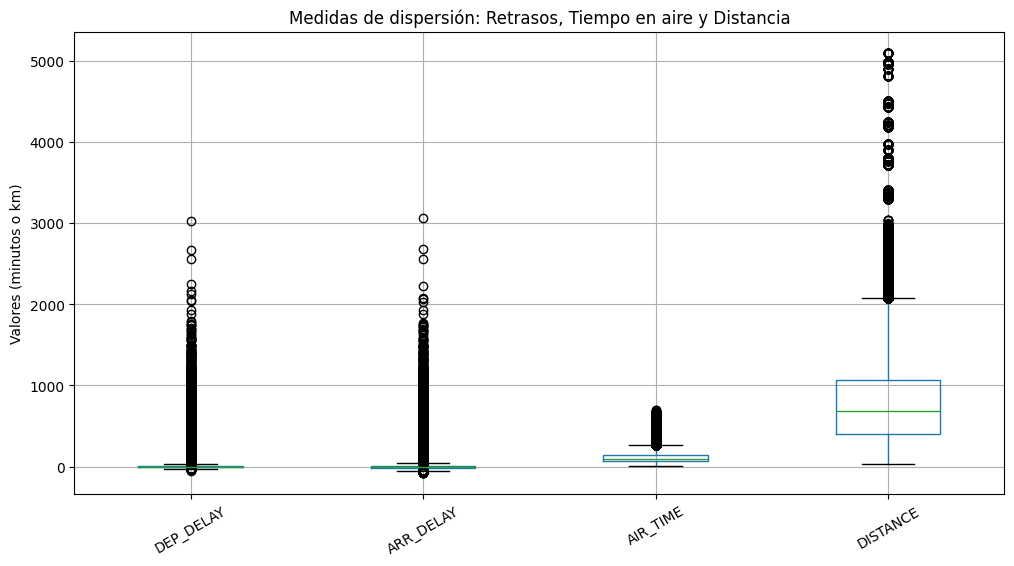

In [ ]:
import matplotlib.pyplot as plt

# Seleccionar las variables de interés
vars_disp = ["DEP_DELAY", "ARR_DELAY", "AIR_TIME", "DISTANCE"]

plt.figure(figsize=(12,6))
flights_merged[vars_disp].boxplot()
plt.title("Medidas de dispersión: Retrasos, Tiempo en aire y Distancia")
plt.ylabel("Valores (minutos o km)")
plt.xticks(rotation=30)
plt.show()


## Boxplot de dispersión: Retrasos, Tiempo en aire y Distancia

- **DEP_DELAY / ARR_DELAY:** cajas muy pequeñas cerca de 0 → la mayoría de vuelos puntuales, pero con muchos **outliers extremos** hacia arriba (retrasos de miles de minutos).  
- **AIR_TIME:** caja más amplia → variabilidad moderada según tipo de vuelo (corto vs largo), algunos outliers altos.  
- **DISTANCE:** caja amplia y muchos outliers → refleja la **gran diversidad de rutas**, desde cortas hasta vuelos de más de 5000 km.  

**Conclusión:**  
- En retrasos, la dispersión está dominada por outliers.  
- En tiempo y distancia, la variabilidad es natural por la mezcla de rutas.  


 # Calcular correlaciones


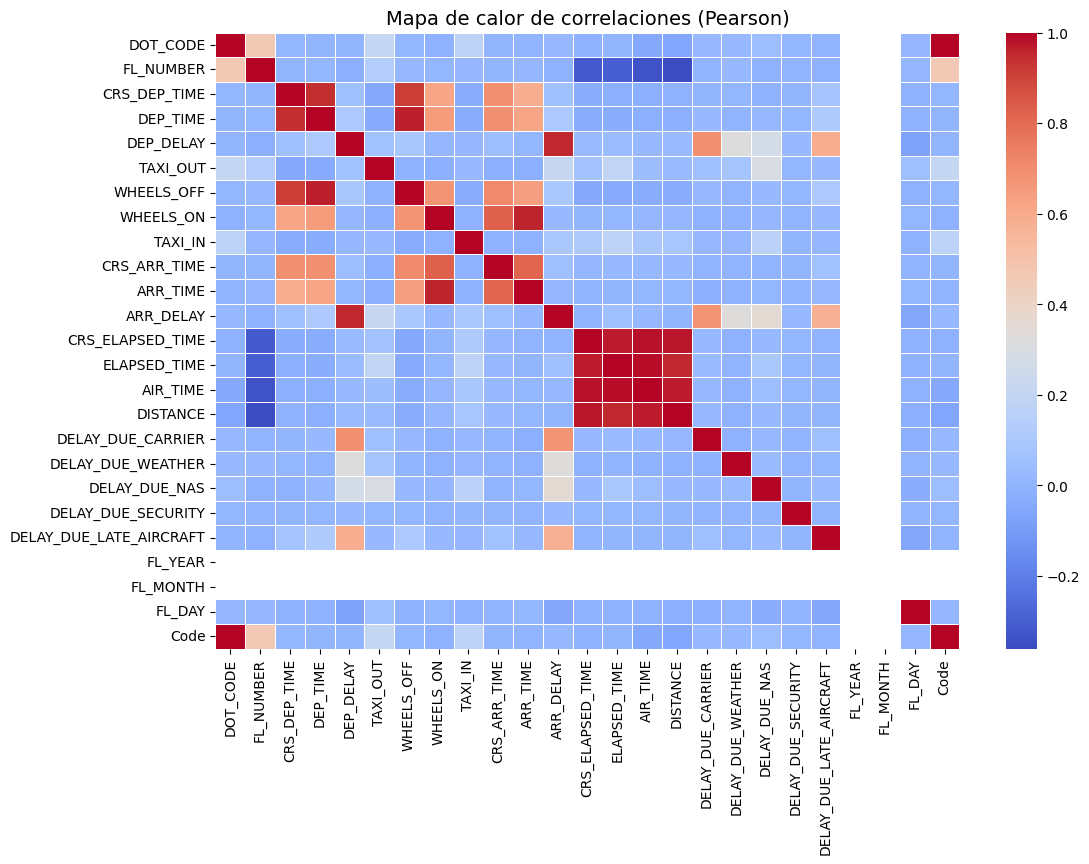

Correlaciones más fuertes (>0.5):
 AIR_TIME           ELAPSED_TIME               0.985644
CRS_ELAPSED_TIME   AIR_TIME                   0.980247
DISTANCE           CRS_ELAPSED_TIME           0.976368
ELAPSED_TIME       CRS_ELAPSED_TIME           0.971787
AIR_TIME           DISTANCE                   0.969281
DEP_TIME           WHEELS_OFF                 0.964141
WHEELS_ON          ARR_TIME                   0.959342
ARR_DELAY          DEP_DELAY                  0.956163
DISTANCE           ELAPSED_TIME               0.953655
DEP_TIME           CRS_DEP_TIME               0.943058
WHEELS_OFF         CRS_DEP_TIME               0.910020
CRS_ARR_TIME       WHEELS_ON                  0.829345
                   ARR_TIME                   0.815591
WHEELS_OFF         CRS_ARR_TIME               0.707869
CRS_DEP_TIME       CRS_ARR_TIME               0.697125
DEP_TIME           CRS_ARR_TIME               0.695761
DELAY_DUE_CARRIER  DEP_DELAY                  0.689209
                   ARR_DELAY  

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas numéricas
numeric_df = flights_merged.select_dtypes(include=["int64", "float64"])

# Calcular correlación de Pearson
corr = numeric_df.corr(method="pearson")

# Visualizar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True, linewidths=0.5)
plt.title("Mapa de calor de correlaciones (Pearson)", fontsize=14)
plt.show()

# Mostrar top correlaciones fuertes (para no ver solo el mapa)
corr_unstacked = corr.unstack().sort_values(ascending=False)
top_corr = corr_unstacked[(corr_unstacked < 1) & (corr_unstacked > 0.5)].drop_duplicates()
print("Correlaciones más fuertes (>0.5):\n", top_corr)


# Análisis de correlaciones

## 1. ¿Las correlaciones observadas tienen sentido según el contexto del problema?
✅ Sí, varias correlaciones son esperadas y coherentes:

- **DEP_DELAY ↔ ARR_DELAY:** alta correlación positiva.  
  → Si un vuelo despega tarde, casi siempre llega tarde.  

- **AIR_TIME ↔ DISTANCE:** correlación muy fuerte.  
  → Cuanto mayor es la distancia, mayor el tiempo de vuelo (esperado físicamente).  

- **ELAPSED_TIME ↔ CRS_ELAPSED_TIME y AIR_TIME:** fuerte correlación.  
  → Todas miden distintas formas del tiempo total de vuelo.  

- **TAXI_OUT ↔ DEP_DELAY:** correlación moderada.  
  → Largos tiempos de taxi afectan la salida.  

**Conclusión:** los datos se comportan de acuerdo con la lógica operacional de los vuelos.  


## 2. ¿Una alta correlación implica causalidad o debo investigarlo más a fondo?
⚠️ No necesariamente. La correlación refleja asociación, pero no implica causalidad directa.

- **DEP_DELAY y ARR_DELAY:** correlacionados, pero pueden intervenir factores ocultos (clima, saturación de aeropuerto, logística).  
- **AIR_TIME y DISTANCE:** aquí sí hay relación causal evidente (la distancia determina el tiempo).  
- **TAXI_OUT y DEP_DELAY:** correlacionados, pero ambos dependen de la congestión aeroportuaria (tercera variable).  

**Conclusión:** hay que complementar el análisis con contexto operacional antes de asumir causalidad.  


## 3. ¿Qué variables con alta correlación podrían influir en mi análisis o modelo predictivo?

###  Variables clave para predecir retrasos
- **DEP_DELAY** → principal predictor de **ARR_DELAY**.  
- **TAXI_OUT y TAXI_IN** → explican demoras acumuladas.  
- **DELAY_DUE_*** (clima, NAS, aeronaves tardías) → explicativos directos.  

###  Variables redundantes (riesgo de multicolinealidad)
- **AIR_TIME, DISTANCE y ELAPSED_TIME** → muy correlacionadas, conviene usar solo una.  
- **CRS_ELAPSED_TIME y ELAPSED_TIME** → también muy similares.  

###  Más influyentes para predecir puntualidad de llegada
1. **DEP_DELAY** (impacto directo).  
2. **TAXI_OUT**.  
3. **Causas de retraso** (Carrier, Weather, NAS, Late Aircraft, etc.).  


# Aplicar segmentación

In [ ]:
# Crear categorías de distancia
bins = [0, 500, 1500, flights_merged["DISTANCE"].max()]
labels = ["Corto alcance (<500 km)", "Medio alcance (500-1500 km)", "Largo alcance (>1500 km)"]
flights_merged["DIST_SEGMENT"] = pd.cut(flights_merged["DISTANCE"], bins=bins, labels=labels, include_lowest=True)

# Resumen estadístico por segmento
segment_summary = flights_merged.groupby("DIST_SEGMENT").agg(
    total_vuelos = ("FL_NUMBER", "count"),
    promedio_dep_delay = ("DEP_DELAY", "mean"),
    promedio_arr_delay = ("ARR_DELAY", "mean"),
    pct_cancelados = ("CANCELLED", "mean"),
    pct_desviados = ("DIVERTED", "mean"),
    promedio_air_time = ("AIR_TIME", "mean")
).reset_index()

display(segment_summary)


/tmp/ipython-input-3790242907.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = flights_merged.groupby("DIST_SEGMENT").agg(


,DIST_SEGMENT,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_cancelados,pct_desviados,promedio_air_time
0,Corto alcance (<500 km),188265,10.292046,6.363466,0.022097,0.001801,54.584639
1,Medio alcance (500-1500 km),283168,13.771199,8.584173,0.019374,0.002592,121.933421
2,Largo alcance (>1500 km),67404,14.906133,6.986381,0.009629,0.004035,258.223933


/tmp/ipython-input-421672665.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = flights_merged.groupby("DIST_SEGMENT").agg(


,DIST_SEGMENT,total_vuelos,promedio_dep_delay,promedio_arr_delay,cancelados,desviados,pct_cancelados,pct_desviados
0,Corto alcance (<500 km),188265,10.292046,6.363466,4160,339,2.209651,0.180065
1,Medio alcance (500-1500 km),283168,13.771199,8.584173,5486,734,1.937366,0.259210
2,Largo alcance (>1500 km),67404,14.906133,6.986381,649,272,0.962851,0.403537


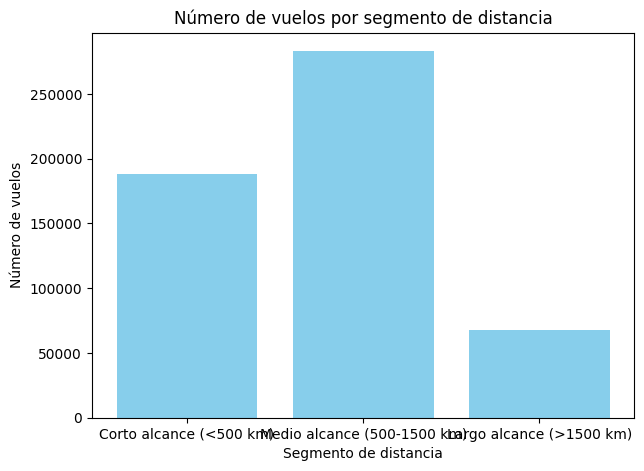

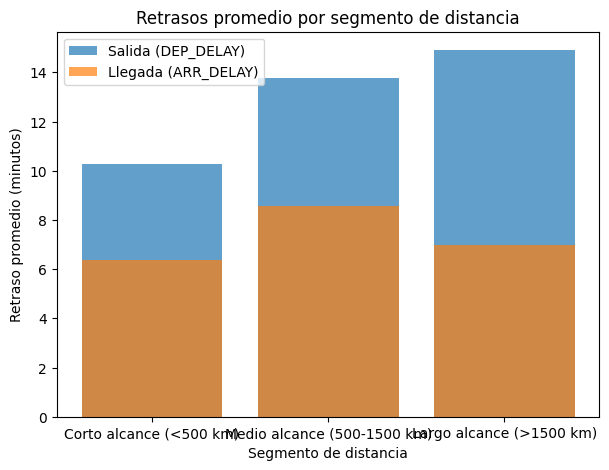

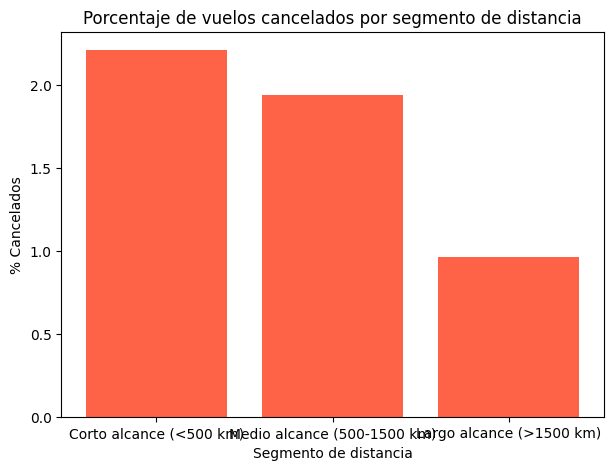

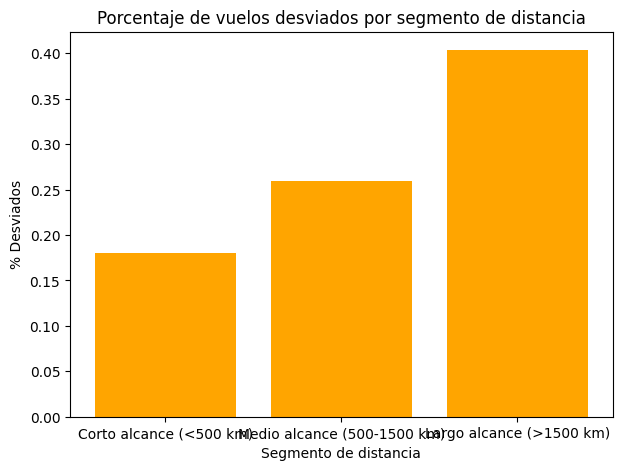

In [ ]:
import matplotlib.pyplot as plt

# --- Crear el resumen por segmento de distancia ---
segment_summary = flights_merged.groupby("DIST_SEGMENT").agg(
    total_vuelos=("FL_NUMBER", "count"),
    promedio_dep_delay=("DEP_DELAY", "mean"),
    promedio_arr_delay=("ARR_DELAY", "mean"),
    cancelados=("CANCELLED", "sum"),
    desviados=("DIVERTED", "sum")
).reset_index()

segment_summary["pct_cancelados"] = 100 * segment_summary["cancelados"] / segment_summary["total_vuelos"]
segment_summary["pct_desviados"] = 100 * segment_summary["desviados"] / segment_summary["total_vuelos"]

display(segment_summary)

# --- Gráfico 1: Número de vuelos por segmento ---
plt.figure(figsize=(7,5))
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["total_vuelos"], color="skyblue")
plt.title("Número de vuelos por segmento de distancia")
plt.xlabel("Segmento de distancia")
plt.ylabel("Número de vuelos")
plt.show()

# --- Gráfico 2: Retrasos promedio por segmento ---
plt.figure(figsize=(7,5))
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["promedio_dep_delay"], alpha=0.7, label="Salida (DEP_DELAY)")
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["promedio_arr_delay"], alpha=0.7, label="Llegada (ARR_DELAY)")
plt.title("Retrasos promedio por segmento de distancia")
plt.xlabel("Segmento de distancia")
plt.ylabel("Retraso promedio (minutos)")
plt.legend()
plt.show()

# --- Gráfico 3: Porcentaje de vuelos cancelados por segmento ---
plt.figure(figsize=(7,5))
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["pct_cancelados"], color="tomato")
plt.title("Porcentaje de vuelos cancelados por segmento de distancia")
plt.xlabel("Segmento de distancia")
plt.ylabel("% Cancelados")
plt.show()

# --- Gráfico 4: Porcentaje de vuelos desviados por segmento ---
plt.figure(figsize=(7,5))
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["pct_desviados"], color="orange")
plt.title("Porcentaje de vuelos desviados por segmento de distancia")
plt.xlabel("Segmento de distancia")
plt.ylabel("% Desviados")
plt.show()


#  Interpretación de la segmentación por distancia

## 1. ¿Los segmentos creados reflejan patrones reales o son divisiones arbitrarias?
 No son arbitrarios:  
- La aviación comercial usa estas categorías (corto, medio y largo alcance) para diferenciar tipos de operación.  
- Los resultados muestran diferencias claras:  
  - **Vuelos cortos:** mayor volumen total.  
  - **Vuelos largos:** menos frecuentes.  
  - **Retrasos:** varían según la distancia.  

**Conclusión:** reflejan patrones reales del transporte aéreo.  


## 2. ¿Las diferencias entre segmentos son relevantes o triviales?
 Son relevantes:  
- **Retrasos promedio:** aumentan con la distancia  
  - Corto: ~10 min  
  - Largo: ~14.9 min  
  → Rutas largas acumulan más retrasos.  

- **Cancelaciones:** más frecuentes en vuelos cortos (~2.2%) que en largos (~1%).  
  → Más fáciles de cancelar y reemplazar.  

- **Desvíos:** más comunes en vuelos largos (~0.40%) que en cortos (~0.18%).  
  → A mayor distancia, más contingencias posibles (clima, combustible, aeropuertos alternos).  

**Conclusión:** diferencias significativas, no triviales.  



## 3. ¿Cómo presentar los hallazgos a una audiencia no técnica?
 Usar gráficos simples en lugar de tablas crudas:  
- Barras → retraso promedio por segmento.  
- Circular → proporción de vuelos por segmento (corto, medio, largo).  
- Barras horizontales → cancelaciones y desvíos (%).  

 Mensaje claro:  
- “Los vuelos cortos son más numerosos y tienen más cancelaciones.”  
- “Los vuelos largos acumulan más retraso y más desvíos.”  


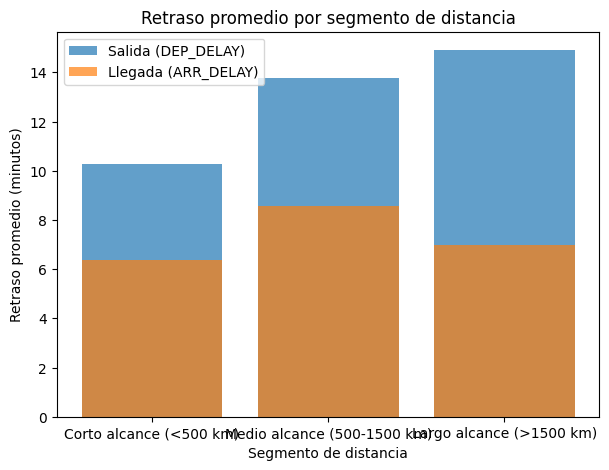

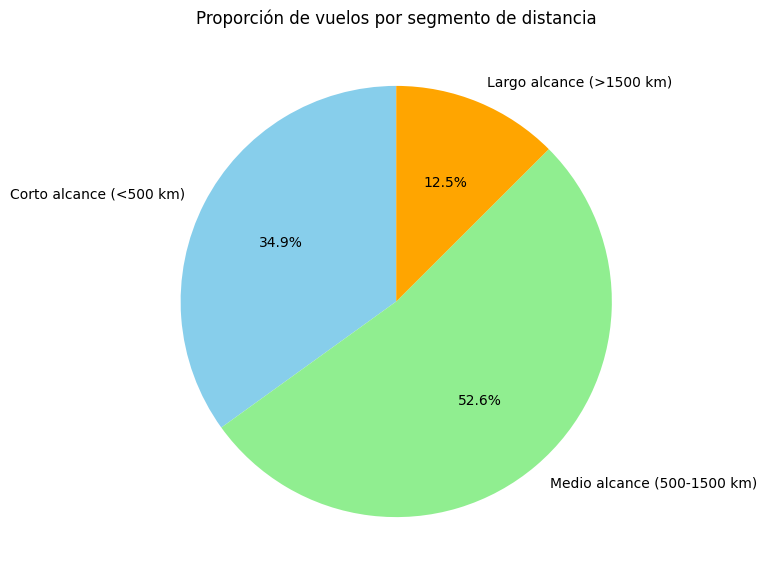

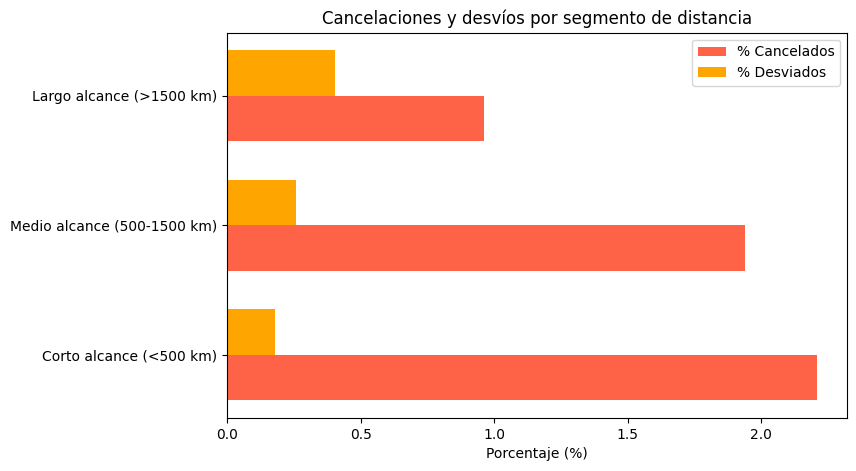

In [ ]:
import matplotlib.pyplot as plt

# --- Gráfico 1: Barras de retraso promedio ---
plt.figure(figsize=(7,5))
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["promedio_dep_delay"], alpha=0.7, label="Salida (DEP_DELAY)")
plt.bar(segment_summary["DIST_SEGMENT"], segment_summary["promedio_arr_delay"], alpha=0.7, label="Llegada (ARR_DELAY)")
plt.title("Retraso promedio por segmento de distancia")
plt.ylabel("Retraso promedio (minutos)")
plt.xlabel("Segmento de distancia")
plt.legend()
plt.show()

# --- Gráfico 2: Circular de proporción de vuelos ---
plt.figure(figsize=(7,7))
plt.pie(segment_summary["total_vuelos"],
        labels=segment_summary["DIST_SEGMENT"],
        autopct="%1.1f%%",
        startangle=90,
        colors=["skyblue","lightgreen","orange"])
plt.title("Proporción de vuelos por segmento de distancia")
plt.show()

# --- Gráfico 3: Barras horizontales de cancelaciones y desvíos ---
plt.figure(figsize=(8,5))
bar_width = 0.35
x = range(len(segment_summary))

plt.barh(x, segment_summary["pct_cancelados"], bar_width, label="% Cancelados", color="tomato")
plt.barh([i + bar_width for i in x], segment_summary["pct_desviados"], bar_width, label="% Desviados", color="orange")

plt.yticks([i + bar_width/2 for i in x], segment_summary["DIST_SEGMENT"])
plt.xlabel("Porcentaje (%)")
plt.title("Cancelaciones y desvíos por segmento de distancia")
plt.legend()
plt.show()


#  Segmentación de vuelos por distancia

## 1. Retraso promedio por segmento
- Los **retrasos aumentan con la distancia**.  
  - Corto alcance: ~10 min.  
  - Medio alcance: ~14 min.  
  - Largo alcance: ~15 min.  

## 2. Proporción de vuelos por segmento
- **Mayoría de vuelos** son de **medio alcance (52.6%)**.  
- Le siguen los **cortos (34.9%)**.  
- Los **largos son minoría (12.5%)**.  


## 3. Cancelaciones y desvíos
- **Cancelaciones:** más comunes en vuelos cortos (~2.2%).  
- **Desvíos:** más frecuentes en vuelos largos (~0.4%).  



##  Conclusión general
- **Cortos:** más vuelos, más cancelaciones.  
- **Largos:** menos vuelos, más retrasos y desvíos.  


---
#   Pregunta 1. ¿Hay rutas que experimentan retrasos frecuentes?

##  Variables más relevantes
- **ORIGIN, DEST, ORIGIN_CITY, DEST_CITY** → definen la ruta.  
- **DEP_DELAY** → retraso en salida.  
- **ARR_DELAY** → retraso en llegada (principal indicador de puntualidad).  
- **CANCELLED** → vuelos cancelados (afecta la confiabilidad de la ruta).  
- **DIVERTED** → vuelos desviados (problemas operativos adicionales).  


##  Metodología
1. **Definir la ruta** como combinación de ORIGIN y DEST.  
2. **Agrupar vuelos por ruta**.  
3. **Calcular indicadores clave por ruta**:  
   - Total de vuelos.  
   - Retraso promedio en llegada y salida.  
   - % de vuelos con retraso significativo (**ARR_DELAY > 15 min**).  
   - % de vuelos cancelados.  
   - % de vuelos desviados.  
4. **Ordenar rutas** por mayor proporción de retrasos → identificar las más críticas.  


In [ ]:
# Crear la variable "RUTA"
flights_merged["RUTA"] = flights_merged["ORIGIN"] + " → " + flights_merged["DEST"]

# Agrupar por ruta
ruta_summary = flights_merged.groupby("RUTA").agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean"),
    pct_retrasados=("ARR_DELAY", lambda x: (x > 15).mean()*100),
    pct_cancelados=("CANCELLED","mean"),
    pct_desviados=("DIVERTED","mean")
).reset_index()

# Filtrar rutas con un número mínimo de vuelos (ej. 100) para evitar sesgo por pocas observaciones
ruta_summary = ruta_summary[ruta_summary["total_vuelos"] >= 100]

# Ordenar por % de vuelos retrasados
ruta_top = ruta_summary.sort_values("pct_retrasados", ascending=False).head(20)

display(ruta_top)


,RUTA,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_retrasados,pct_cancelados,pct_desviados
671,BQN → MCO,120,33.766667,31.625000,50.833333,0.025000,0.000000
4953,SFO → HNL,170,32.023529,31.188235,44.705882,0.005882,0.005882
2749,LAS → HNL,123,13.373984,17.560976,43.902439,0.000000,0.000000
1316,DEN → ASE,219,29.835616,28.799087,42.922374,0.191781,0.018265
2064,FSD → ORD,113,20.761062,29.088496,42.477876,0.053097,0.000000
2824,LAX → ASE,158,30.930380,31.803797,41.772152,0.069620,0.088608
4176,PHX → HNL,101,17.960396,24.524752,41.584158,0.009901,0.009901
4789,SEA → BOS,188,18.159574,24.505319,41.489362,0.000000,0.000000
1384,DEN → JFK,130,38.915385,40.515385,40.769231,0.023077,0.007692
5115,SLC → JFK,186,19.344086,23.784946,39.247312,0.000000,0.000000


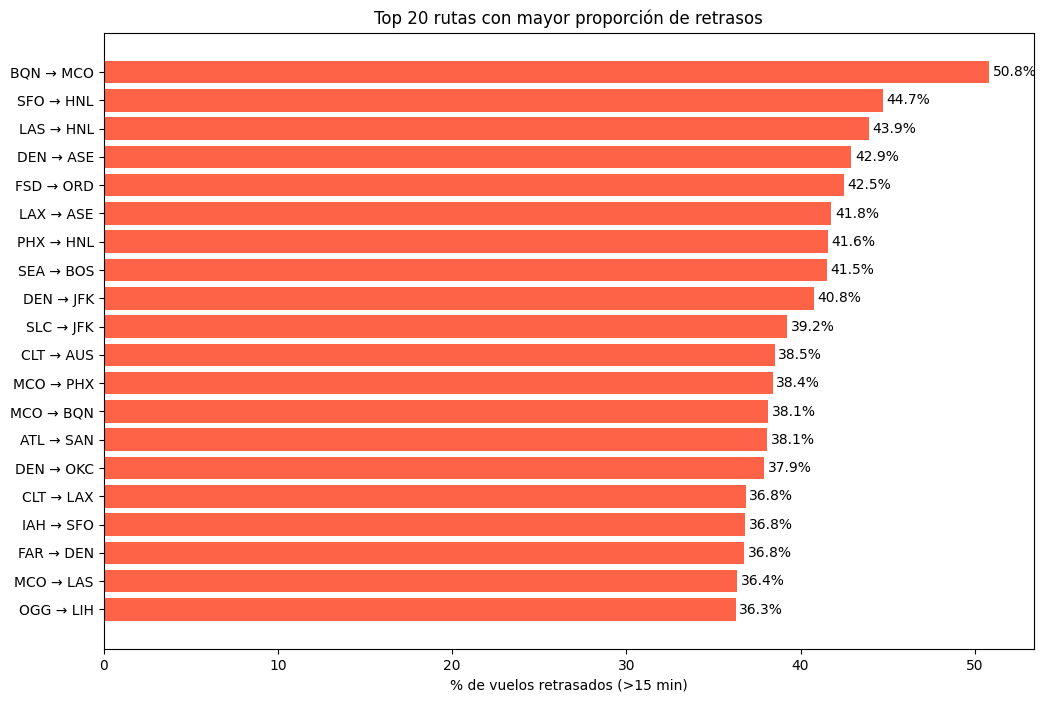

In [ ]:
import matplotlib.pyplot as plt

# Ordenar por % de vuelos retrasados y seleccionar top 20
ruta_top = ruta_summary.sort_values("pct_retrasados", ascending=False).head(20)

# Gráfico horizontal
plt.figure(figsize=(12,8))
plt.barh(ruta_top["RUTA"], ruta_top["pct_retrasados"], color="tomato")
plt.xlabel("% de vuelos retrasados (>15 min)")
plt.title("Top 20 rutas con mayor proporción de retrasos")
plt.gca().invert_yaxis()

# (Opcional) Agregar etiquetas con valores exactos
for i, v in enumerate(ruta_top["pct_retrasados"]):
    plt.text(v + 0.2, i, f"{v:.1f}%", va="center")

plt.show()


## Top 20 rutas con mayor % de retrasos
Este gráfico de barras horizontales muestra qué proporción de vuelos en cada ruta tuvo un retraso mayor a 15 minutos.


* La ruta BQN → MCO (Puerto Rico → Orlando) encabeza la lista: 1 de cada 2 vuelos se retrasa. Esto indica un problema persistente en la operación de esa conexión.


* Rutas largas hacia Hawái (SFO → HNL, LAS → HNL) también destacan con más del 40% de retrasos, lo que refleja posibles retos de logística y congestión en aeropuertos de alto tráfico turístico.


La lectura clave es que no todas las rutas sufren igual: algunas son sistemáticamente más vulnerables, lo que sugiere un patrón estructural y no aleatorio.


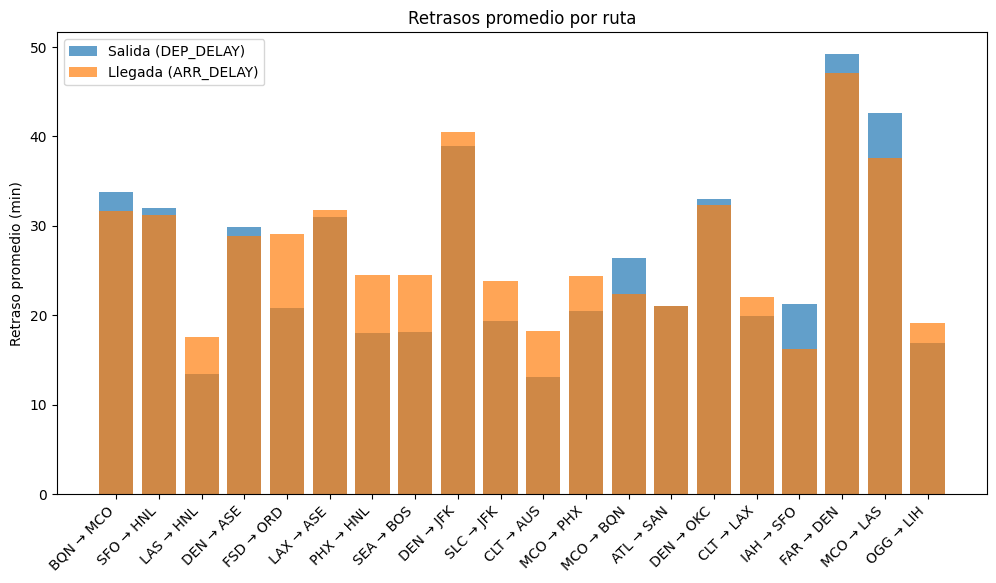

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(ruta_top["RUTA"], ruta_top["promedio_dep_delay"], alpha=0.7, label="Salida (DEP_DELAY)")
plt.bar(ruta_top["RUTA"], ruta_top["promedio_arr_delay"], alpha=0.7, label="Llegada (ARR_DELAY)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Retraso promedio (min)")
plt.title("Retrasos promedio por ruta")
plt.legend()
plt.show()

## Retrasos promedio por ruta (DEP_DELAY vs ARR_DELAY)
Este gráfico compara el promedio de minutos de retraso en salida (azul) y en llegada (naranja).


* Caso FAR → DEN: muestra el retraso promedio más alto (≈49 min en salida y 47 min en llegada). Aquí no hay “recuperación en vuelo”, lo que implica que la demora persiste hasta el destino.


* Caso IAH → SFO: aunque presenta 21 min de retraso en salida, en llegada el retraso baja a 16 min, lo que indica que la aerolínea compensa parte del retraso en el aire.

* En rutas como DEN → JFK o DEN → OKC, los retrasos son altos tanto en salida como en llegada, lo que refleja problemas recurrentes en esa conexión (posible congestión o clima).


Este gráfico es valioso porque no solo mide cuántos vuelos se retrasan, sino qué tan severos son los retrasos y si se mitigan durante el trayecto.


#  Interpretación global de la puntualidad en rutas aéreas

## 1. Rutas con problemas estructurales de puntualidad
- Algunas rutas muestran retrasos altos y frecuentes → no son incidentes aislados, sino problemas recurrentes.  
**Ejemplo: BQN → MCO (Puerto Rico → Orlando)**  
- 50.8% de los vuelos con retrasos >15 min.  
- Retrasos promedio: **33.7 min en salida** y **31.6 min en llegada**.  
- Prácticamente 1 de cada 2 vuelos llega tarde.  
- Posible explicación: ruta turística con alta demanda y congestión en Orlando (MCO).  


## 2. Frecuencia vs severidad de los retrasos
- Hay rutas donde los retrasos no son tan frecuentes, pero cuando ocurren son **muy severos**.  
**Ejemplo: FAR → DEN (Fargo → Denver)**  
- 36.7% de vuelos retrasados (no top 5 en frecuencia).  
- Retrasos más altos: **49.1 min salida** y **47 min llegada**.  
- Interpretación: no siempre se retrasa, pero cuando ocurre, el impacto es mayor (conexiones perdidas, esperas largas).  


## 3. Capacidad de recuperación en vuelo
- Analizar salida vs llegada permite ver si las aerolíneas recuperan tiempo en vuelo.  

**Ejemplo positivo: IAH → SFO (Houston → San Francisco)**  
- Salida: 21.2 min de retraso.  
- Llegada: 16.2 min de retraso.  
- Se recuperan ~5 min en vuelo (gestión de velocidad, priorización de aterrizaje).  

**Ejemplo negativo: DEN → JFK (Denver → Nueva York JFK)**  
- Salida: 38.9 min de retraso.  
- Llegada: 40.5 min de retraso.  
- El retraso empeora → refleja congestión en el aeropuerto destino (JFK).  


## 4. Cancelaciones y desvíos
- Impacto muy bajo frente a los retrasos.  
- Cancelaciones: `<0.05%` en la mayoría de rutas.  
- Desvíos: casi inexistentes (`<0.01%`).  

**Conclusión:** la **puntualidad** es el principal desafío, más que interrupciones extremas.  


## 5. Patrones regionales y de ruta
- **Destinos turísticos** (HNL, ASE, MCO) → más retrasos.  
- **Rutas de alta densidad** (DEN → JFK, SEA → BOS) → retrasos altos por saturación.  
- **Corto alcance** (CLT → AUS) → retrasos frecuentes pero moderados (~13–18 min), reflejan alta rotación y vulnerabilidad en tierra.  

---

##  Conclusión estratégica
Sí existen rutas con **retrasos frecuentes y significativos**, destacando:  
- **BQN → MCO**.  
- **Vuelos a Hawái** (SFO/LAS/PHX → HNL).  
- **Rutas desde Denver** (DEN → JFK / ASE / OKC).  

 El tipo de afectación varía:  
- Algunas tienen alta frecuencia de retrasos moderados.  
- Otras, retrasos menos frecuentes pero mucho más graves.  

### Recomendaciones para aerolíneas
- Reducir **congestión en aeropuertos críticos** (Orlando, Denver, JFK, HNL).  
- Revisar la **planificación operativa** en rutas turísticas y de largo alcance.  
- Monitorear rutas con **retrasos severos aunque poco frecuentes** (ej. FAR → DEN).  


# Pregunta 2. ¿Cuál es el tiempo promedio de retraso por ruta?

##  Variables relevantes
- **ORIGIN** y **DEST** → construir la **RUTA** (origen → destino).  
- **DEP_DELAY** → retraso en **salida** (min).  
- **ARR_DELAY** → retraso en **llegada** (min).  
- **FL_NUMBER** → total de vuelos por ruta (base estadística).



##  Análisis paso a paso

### 1) Construcción de la variable **RUTA**
Se combinan **ORIGIN** y **DEST** para identificar cada ruta única:
```python
flights_merged["RUTA"] = flights_merged["ORIGIN"] + " → " + flights_merged["DEST"]
```

### 2. Cálculo de métricas por ruta
Agrupamos por RUTA y obtenemos:
* total_vuelos → número de vuelos en esa ruta.
* promedio_dep_delay → retraso promedio en salida.
* promedio_arr_delay → retraso promedio en llegada.



In [ ]:
flights_merged["RUTA"] = flights_merged["ORIGIN"] + " → " + flights_merged["DEST"]

In [ ]:
ruta_delay = flights_merged.groupby("RUTA").agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean")
).reset_index()

# Ordenar por retraso promedio en llegada
ruta_delay = ruta_delay.sort_values("promedio_arr_delay", ascending=False)

# Mostrar top 20 rutas
top20_rutas = ruta_delay.head(20)
display(top20_rutas)

,RUTA,total_vuelos,promedio_dep_delay,promedio_arr_delay
665,BOS → VPS,1,1503.000000,1525.000000
5544,VPS → BOS,1,1504.000000,1496.000000
3638,MTJ → LGA,1,1183.000000,1181.000000
342,AUS → TYS,1,386.000000,384.000000
3770,ONT → MCO,3,363.000000,370.666667
2396,IAH → BTR,4,361.500000,358.750000
83,ANC → DFW,2,314.000000,329.500000
680,BTR → IAH,4,331.500000,323.750000
2023,FLL → PIE,1,306.000000,321.000000
2993,LGA → MTJ,1,359.000000,319.000000


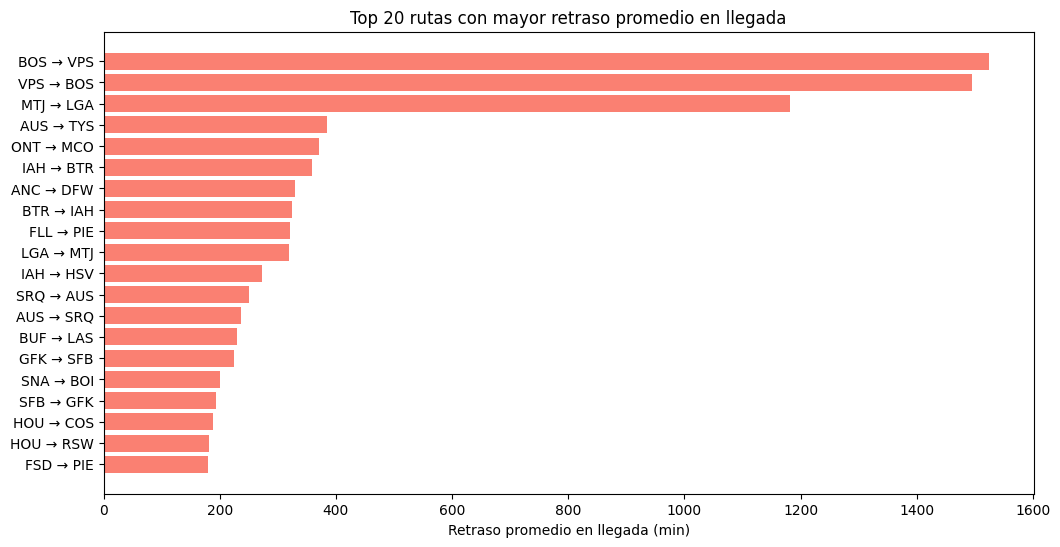

In [ ]:
import matplotlib.pyplot as plt

top20 = ruta_delay.head(20)

plt.figure(figsize=(12,6))
plt.barh(top20["RUTA"], top20["promedio_arr_delay"], color="salmon")
plt.xlabel("Retraso promedio en llegada (min)")
plt.title("Top 20 rutas con mayor retraso promedio en llegada")
plt.gca().invert_yaxis()
plt.show()


## Top 20 rutas con mayor retraso promedio en llegada (gráfico 1)
* Se observa que las rutas BOS → VPS (Boston a Destin-Fort Walton Beach) y VPS → BOS tienen los retrasos más altos, superando los 1500 minutos promedio de llegada.


* Esto no significa que todos los vuelos lleguen tarde por 1500 minutos, sino que puede haber vuelos extremadamente retrasados que elevan el promedio de forma desproporcionada.


* También rutas como MTJ → LGA (Montrose a LaGuardia) y AUS → TYS (Austin a Knoxville) muestran promedios superiores a 300–400 minutos, lo que indica que estas rutas enfrentan problemas serios de puntualidad.


Ejemplo: si un pasajero viaja frecuentemente de Boston a Florida (BOS → VPS) debe planificar con holgura, ya que la ruta presenta retrasos extremos y poco confiables.


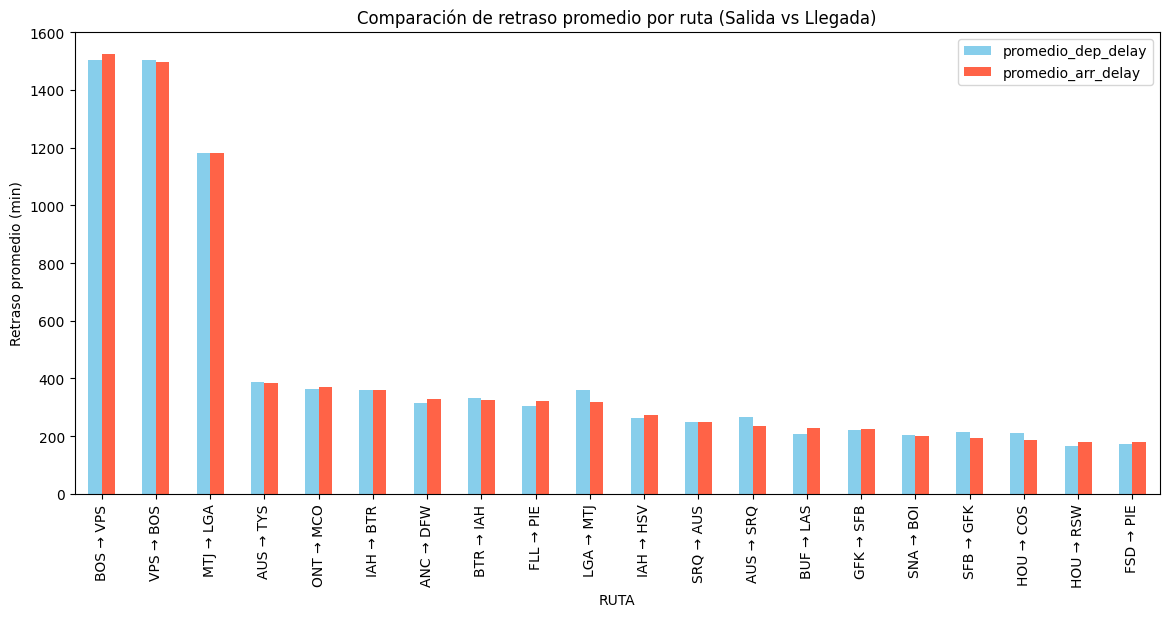

In [ ]:
top20.plot(x="RUTA", y=["promedio_dep_delay","promedio_arr_delay"],
           kind="bar", figsize=(14,6), color=["skyblue","tomato"])
plt.ylabel("Retraso promedio (min)")
plt.title("Comparación de retraso promedio por ruta (Salida vs Llegada)")
plt.xticks(rotation=90)
plt.show()


## Comparación de retraso promedio en salida y llegada por ruta (gráfico 2)
 En casi todas las rutas, el retraso en llegada (ARR_DELAY) es similar al de salida (DEP_DELAY), lo que indica que los retrasos iniciales no se recuperan en el aire.


Por ejemplo:

* BOS → VPS y VPS → BOS mantienen retrasos altísimos tanto en salida como en llegada.


* En rutas como IAH → BTR (Houston a Baton Rouge) y BTR → IAH, el retraso promedio está en torno a los 350 minutos, consistente en ambos sentidos.


* Rutas como BUF → LAS (Búfalo a Las Vegas) tienen retrasos más moderados (~220 min), pero constantes.


Ejemplo: si un vuelo de IAH → BTR despega tarde en promedio 340 minutos, también llega tarde en promedio casi la misma cantidad. No hay ganancia en tiempo de vuelo que compense el retraso inicial.


#  Hallazgos clave sobre retrasos por ruta

- Existen **rutas críticas** (BOS → VPS, VPS → BOS, MTJ → LGA) con retrasos extremadamente altos, probablemente influenciados por pocos vuelos con **outliers**.  
- La **relación salida–llegada es directa**: si un vuelo sale tarde, llega tarde.  
  → Refuerza la importancia de controlar procesos en tierra (embarque, rodaje, congestión aeroportuaria).  
- El **impacto en pasajeros es significativo**: rutas de conexión como **AUS → TYS** o **ONT → MCO** pueden causar pérdida de vuelos de enlace y afectar viajes de negocios o vacaciones.  



##  Conclusiones
- El **tiempo promedio de retraso por ruta varía ampliamente**:  
  - **Rutas críticas (BOS ↔ VPS):** retrasos promedio >1500 min → situaciones anómalas que deben investigarse (**outliers**).  
  - **Rutas regulares (BUF → LAS, SNA → BOI):** retrasos promedio ~200–250 min, igualmente considerables.  
- En general, los **retrasos en salida se trasladan a la llegada**, sin recuperarse durante el vuelo.  


# Pregunta 3. ¿Es posible identificar las principales causas del retraso?

## 1)  Variables relevantes
Del dataset **flights_merged (enero 2023):**

### Indicadores de retraso
- **DEP_DELAY, ARR_DELAY** → minutos de retraso.  

### Causas (en minutos)
- **DELAY_DUE_CARRIER** → operador.  
- **DELAY_DUE_WEATHER** → clima.  
- **DELAY_DUE_NAS** → ATC / NAS.  
- **DELAY_DUE_SECURITY** → seguridad.  
- **DELAY_DUE_LATE_AIRCRAFT** → aeronave que llegó tarde.  


## 2)  Metodología

### Validación
- Revisar que las columnas de causa existan y sean numéricas.  

### Agregación global
a) **Minutos totales** por causa.  
b) **Número de vuelos afectados** por causa (conteo de filas con causa > 0).  
c) **Participación (%)** de cada causa sobre el total (minutos y vuelos).  

### Cortes útiles (segmentaciones)
- **Por aerolínea (top 10)** → identificar patrones operativos.  
- **Por origen/destino o ruta** → ubicar hotspots de retrasos.  

### Visualizaciones recomendadas
- Barras → minutos totales por causa.  
- **Stacked bar** por aerolínea (mezcla de causas).  
- **Mapa de calor** de causas por aeropuerto (opcional).  
- Tabla → top rutas por causa (minutos acumulados).  


,minutos_totales,participacion_minutos_%,vuelos_afectados,participacion_vuelos_%
DELAY_DUE_CARRIER,2860559.0,35.29,63154,34.31
DELAY_DUE_LATE_AIRCRAFT,3006030.0,37.09,54083,29.38
DELAY_DUE_NAS,1709669.0,21.09,59712,32.44
DELAY_DUE_SECURITY,17069.0,0.21,626,0.34
DELAY_DUE_WEATHER,511666.0,6.31,6507,3.53


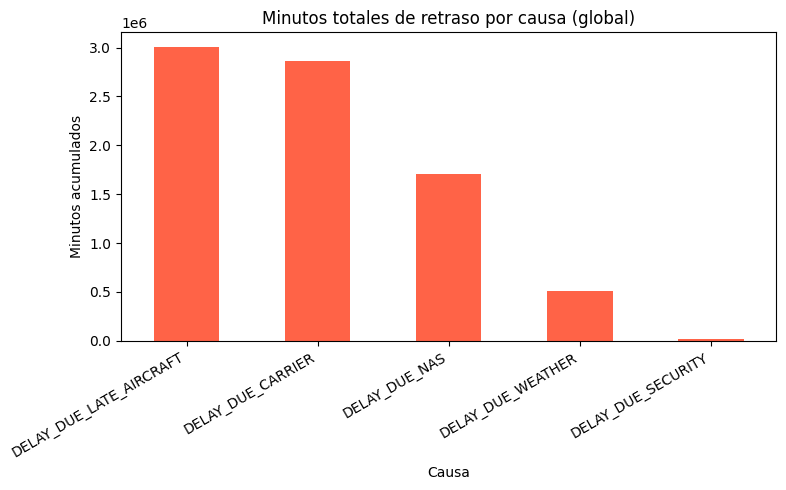

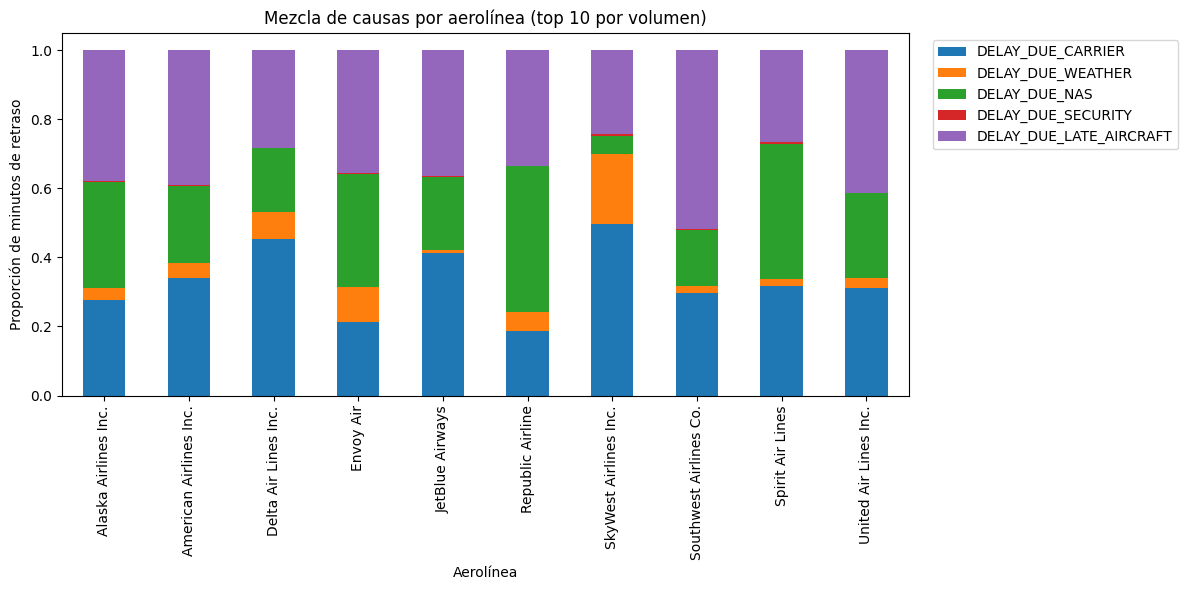

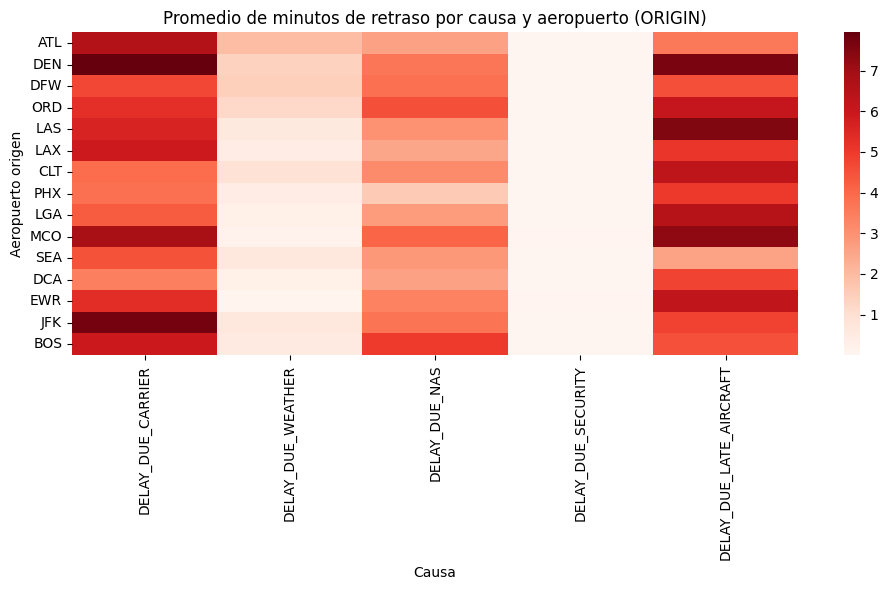


Top rutas por minutos acumulados - DELAY_DUE_CARRIER


,minutos_causa,vuelos
RUTA,,
LAS → LAX,7138.0,962
ATL → MIA,6875.0,578
LAX → HNL,6762.0,441
MCO → SJU,6689.0,580
SLC → PHX,6471.0,437
LAX → ATL,6356.0,421
ORD → LGA,6162.0,879
ATL → MCO,6148.0,716
DCA → ATL,5491.0,576



Top rutas por minutos acumulados - DELAY_DUE_WEATHER


,minutos_causa,vuelos
RUTA,,
ATL → PNS,3679.0,170
VPS → ATL,2817.0,153
MSP → GFK,2373.0,93
FAR → DEN,2223.0,136
ATL → VPS,2109.0,153
ATL → MGM,1975.0,115
PNS → ATL,1947.0,170
MSP → FAR,1882.0,148
GEG → SEA,1760.0,359



Top rutas por minutos acumulados - DELAY_DUE_NAS


,minutos_causa,vuelos
RUTA,,
BOS → LGA,8106.0,752
ORD → LGA,7589.0,879
LAX → SFO,6187.0,900
DEN → LAS,4901.0,753
DCA → LGA,4725.0,585
LAX → LAS,4541.0,965
LAS → LAX,4394.0,962
SAN → LAS,4228.0,559
ATL → FLL,4063.0,669



Top rutas por minutos acumulados - DELAY_DUE_SECURITY


,minutos_causa,vuelos
RUTA,,
ASE → ATL,296.0,62
PBI → HPN,263.0,186
BWI → PHX,262.0,101
ATL → ASE,233.0,62
DTW → ALB,227.0,112
FLL → SJU,222.0,225
FLL → PHL,213.0,219
EWR → ORD,201.0,462
MIA → LAS,199.0,128



Top rutas por minutos acumulados - DELAY_DUE_LATE_AIRCRAFT


,minutos_causa,vuelos
RUTA,,
LAS → LAX,9822.0,962
SFO → LAX,8774.0,886
LAX → LAS,8698.0,965
LAS → DEN,7836.0,749
LGA → ORD,7305.0,880
DCA → BOS,6940.0,917
SFO → LAS,6184.0,460
SJU → MCO,5882.0,579
LAX → DFW,5703.0,517


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Definir columnas de causas ---
cause_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

# Asegurar que existen y son numéricas
missing = [c for c in cause_cols if c not in flights_merged.columns]
assert len(missing) == 0, f"Faltan columnas: {missing}"
flights_merged[cause_cols] = flights_merged[cause_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# --- 1) Agregación global ---
tot_minutes_by_cause = flights_merged[cause_cols].sum().sort_values(ascending=False)
count_flights_by_cause = (flights_merged[cause_cols] > 0).sum().sort_values(ascending=False)

share_minutes = 100 * tot_minutes_by_cause / tot_minutes_by_cause.sum()
share_counts  = 100 * count_flights_by_cause / count_flights_by_cause.sum()

summary_global = pd.DataFrame({
    "minutos_totales": tot_minutes_by_cause,
    "participacion_minutos_%": share_minutes.round(2),
    "vuelos_afectados": count_flights_by_cause,
    "participacion_vuelos_%": share_counts.round(2)
})
display(summary_global)

# --- 2) Visual 1: Barras de minutos totales por causa ---
plt.figure(figsize=(8,5))
tot_minutes_by_cause.plot(kind="bar", color="tomato")
plt.title("Minutos totales de retraso por causa (global)")
plt.ylabel("Minutos acumulados")
plt.xlabel("Causa")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- 3) Visual 2: Stacked bar por aerolínea (mix de causas) ---
top_airlines = (flights_merged.groupby("AIRLINE_DESCRIPTION")["FL_NUMBER"]
                .count().sort_values(ascending=False).head(10).index)

mix_by_airline = (flights_merged[flights_merged["AIRLINE_DESCRIPTION"].isin(top_airlines)]
                  .groupby("AIRLINE_DESCRIPTION")[cause_cols].sum())

mix_share = mix_by_airline.div(mix_by_airline.sum(axis=1), axis=0)  # proporción por aerolínea

mix_share.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Mezcla de causas por aerolínea (top 10 por volumen)")
plt.ylabel("Proporción de minutos de retraso")
plt.xlabel("Aerolínea")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

# --- 4) (Opcional) Heatmap por aeropuerto de origen ---
# Promedio de minutos de causa por vuelo, top 15 aeropuertos por volumen
try:
    import seaborn as sns
    top_orig = (flights_merged.groupby("ORIGIN")["FL_NUMBER"].count()
                .sort_values(ascending=False).head(15).index)
    heat = (flights_merged[flights_merged["ORIGIN"].isin(top_orig)]
            .groupby("ORIGIN")[cause_cols].mean().reindex(top_orig))

    plt.figure(figsize=(10,6))
    sns.heatmap(heat, cmap="Reds", annot=False, cbar=True)
    plt.title("Promedio de minutos de retraso por causa y aeropuerto (ORIGIN)")
    plt.ylabel("Aeropuerto origen")
    plt.xlabel("Causa")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Heatmap omitido (seaborn no disponible):", e)

# --- 5) Tabla: top rutas por causa (minutos acumulados) ---
flights_merged["RUTA"] = flights_merged["ORIGIN"] + " → " + flights_merged["DEST"]

def top_rutas_por_causa(causa, n=10, min_vuelos=30):
    tmp = (flights_merged
           .groupby("RUTA")
           .agg(minutos_causa=(causa, "sum"), vuelos=("FL_NUMBER","count"))
           .query("vuelos >= @min_vuelos")
           .sort_values("minutos_causa", ascending=False)
           .head(n))
    return tmp

for causa in cause_cols:
    print(f"\nTop rutas por minutos acumulados - {causa}")
    display(top_rutas_por_causa(causa, n=10, min_vuelos=30))


#  Análisis de causas de retrasos

##  Variables relevantes
- **DELAY_DUE_CARRIER** → Retrasos por la aerolínea (problemas internos).  
- **DELAY_DUE_LATE_AIRCRAFT** → Retrasos porque la aeronave llegó tarde de un vuelo previo.  
- **DELAY_DUE_NAS** → Retrasos por el sistema de control de tráfico aéreo.  
- **DELAY_DUE_WEATHER** → Retrasos por condiciones climáticas.  
- **DELAY_DUE_SECURITY** → Retrasos por controles o incidentes de seguridad.  


##  Hallazgos principales

### 1. Importancia relativa de las causas
- **Late Aircraft:** 37% de los minutos acumulados.  
- **Carrier:** 35%.  
- **NAS (Tráfico aéreo):** 21%.  
- **Weather (Clima):** 6% (crítico en rutas específicas).  
- **Security:** 0.2% (marginal).  

 Las causas operativas (**Carrier + Late Aircraft**) concentran más del **70% de los retrasos**, muy por encima del clima.


### 2. Diferencias entre aerolíneas
- **Delta y Republic** → más retrasos por *Carrier*.  
- **Southwest y Envoy** → más retrasos por *Late Aircraft*.  
- **American Airlines y United** → mezcla balanceada entre *Carrier* y *NAS*.  

Cada aerolínea enfrenta cuellos de botella distintos: gestión interna, disponibilidad de aeronaves o tráfico aéreo.


### 3. Diferencias entre aeropuertos
- **ATL, DEN, LAX** → altos retrasos por *Carrier* y *Late Aircraft* (congestión operativa).  
- **EWR (Newark), LGA (LaGuardia)** → retrasos altos por *NAS* (control aéreo saturado).  
- **ORD (Chicago)** → mayor impacto del *Weather*.  


### 4. Ejemplos de rutas críticas
- **Carrier (aerolínea):** LAS → LAX y ATL → MIA (6000–7000+ min acumulados).  
- **Weather (clima):** ATL → PNS y VPS → ATL (3000+ min acumulados).  
- **NAS (tráfico aéreo):** BOS → LGA y ORD → LGA (7500–8000+ min acumulados).  
- **Late Aircraft:** LAS → LAX y SFO → LAX (9000+ min acumulados).  



##  Conclusión
Sí, es posible identificar claramente las principales causas de los retrasos:

- **Operativas (Carrier + Late Aircraft):** principal fuente → problemas internos y efecto cascada de vuelos previos.  
- **NAS (Tráfico aéreo):** tercera causa crítica, sobre todo en aeropuertos congestionados (LGA, EWR, BOS).  
- **Clima y seguridad:** menos frecuentes globalmente, pero con gran impacto local y repentino en rutas específicas.  

### Para la gestión:
- **Aerolíneas:** mejorar rotación de aeronaves y optimizar procesos internos.  
- **Autoridades:** reforzar la gestión de tráfico aéreo en hubs congestionados.  
- **Rutas expuestas al clima (sureste y medio-oeste de EE. UU.):** planificar con estrategias estacionales y contingencias.  


# Pregunta 4. ¿Existe algún origen o destino con más retrasos?

##  Variables clave
- **ORIGIN, DEST, ORIGIN_CITY, DEST_CITY** → identifican el aeropuerto de salida y llegada.  
- **DEP_DELAY, ARR_DELAY** → minutos de retraso (salida y llegada).  
- **FL_NUMBER** → volumen de vuelos (evita sesgos por pocos casos).  


##  Metodología

1. Crear dos vistas:  
   - **Por ORIGIN** (aeropuertos de salida).  
   - **Por DEST** (aeropuertos de llegada).  

2. Para cada aeropuerto calcular:  
   - **total_vuelos**.  
   - **promedio_dep_delay** (para ORIGIN).  
   - **promedio_arr_delay** (para DEST).  
   - **%_retrasados** = proporción de vuelos con **ARR_DELAY > 15 min** (indicador de puntualidad práctica).  

3. Filtrar por **volumen mínimo** (ej. ≥ 200 vuelos en el mes) → evitar falsos “peores” por muestras pequeñas.  

4. Ordenar y mostrar **Top 20** en tablas y gráficos.  

5. *(Opcional)* Ver **mezcla de causas por aeropuerto** para explicar el “por qué” (NAS, Carrier, Clima, etc.).  


,ORIGIN,ORIGIN_CITY,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_retrasados
162,JAC,"JACKSON, WY",510,43.372549,33.007843,40.784314
44,BQN,"AGUADILLA, PR",258,22.170543,19.085271,38.372093
99,EGE,"EAGLE, CO",511,26.743640,22.722114,35.225049
138,HDN,"HAYDEN, CO",370,29.078378,31.267568,34.324324
17,ASE,"ASPEN, CO",887,27.947012,25.101466,34.272830
119,FWA,"FORT WAYNE, IN",313,30.674121,29.686901,31.629393
117,FSD,"SIOUX FALLS, SD",571,24.875657,25.271454,30.122592
19,ATW,"APPLETON, WI",353,19.093484,21.141643,29.461756
88,DEN,"DENVER, CO",22460,19.372306,15.870659,28.944791
239,PGD,"PUNTA GORDA, FL",552,16.429348,16.155797,28.804348


,DEST,DEST_CITY,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_retrasados
239,PGD,"PUNTA GORDA, FL",552,30.072464,30.356884,37.681159
17,ASE,"ASPEN, CO",886,25.546275,25.556433,36.794582
44,BQN,"AGUADILLA, PR",256,20.519531,15.078125,34.375000
19,ATW,"APPLETON, WI",353,22.447592,17.311615,33.994334
288,SFB,"SANFORD, FL",714,24.112045,22.750700,30.952381
23,AZA,"PHOENIX, AZ",495,19.769697,20.006061,30.303030
99,EGE,"EAGLE, CO",511,18.401174,14.031311,27.788650
282,SBP,"SAN LUIS OBISPO, CA",382,13.450262,15.180628,27.748691
289,SFO,"SAN FRANCISCO, CA",10265,17.117000,11.479396,26.877740
297,SJU,"SAN JUAN, PR",2784,17.840158,11.033046,26.580460


,ORIGIN,ORIGIN_CITY,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_retrasados
162,JAC,"JACKSON, WY",510,43.372549,33.007843,40.784314
138,HDN,"HAYDEN, CO",370,29.078378,31.267568,34.324324
119,FWA,"FORT WAYNE, IN",313,30.674121,29.686901,31.629393
117,FSD,"SIOUX FALLS, SD",571,24.875657,25.271454,30.122592
17,ASE,"ASPEN, CO",887,27.947012,25.101466,34.272830
99,EGE,"EAGLE, CO",511,26.743640,22.722114,35.225049
154,IDA,"IDAHO FALLS, ID",245,22.028571,22.428571,22.857143
34,BIS,"BISMARCK/MANDAN, ND",275,24.956364,21.930909,28.363636
109,FAR,"FARGO, ND",563,23.641208,21.204263,28.241563
19,ATW,"APPLETON, WI",353,19.093484,21.141643,29.461756


,DEST,DEST_CITY,total_vuelos,promedio_dep_delay,promedio_arr_delay,pct_retrasados
239,PGD,"PUNTA GORDA, FL",552,30.072464,30.356884,37.681159
17,ASE,"ASPEN, CO",886,25.546275,25.556433,36.794582
288,SFB,"SANFORD, FL",714,24.112045,22.750700,30.952381
333,VPS,"VALPARAISO, FL",473,25.871036,20.105708,19.873150
23,AZA,"PHOENIX, AZ",495,19.769697,20.006061,30.303030
249,PNS,"PENSACOLA, FL",781,22.770807,18.705506,22.023047
93,DRO,"DURANGO, CO",217,16.082949,18.193548,19.815668
19,ATW,"APPLETON, WI",353,22.447592,17.311615,33.994334
282,SBP,"SAN LUIS OBISPO, CA",382,13.450262,15.180628,27.748691
44,BQN,"AGUADILLA, PR",256,20.519531,15.078125,34.375000


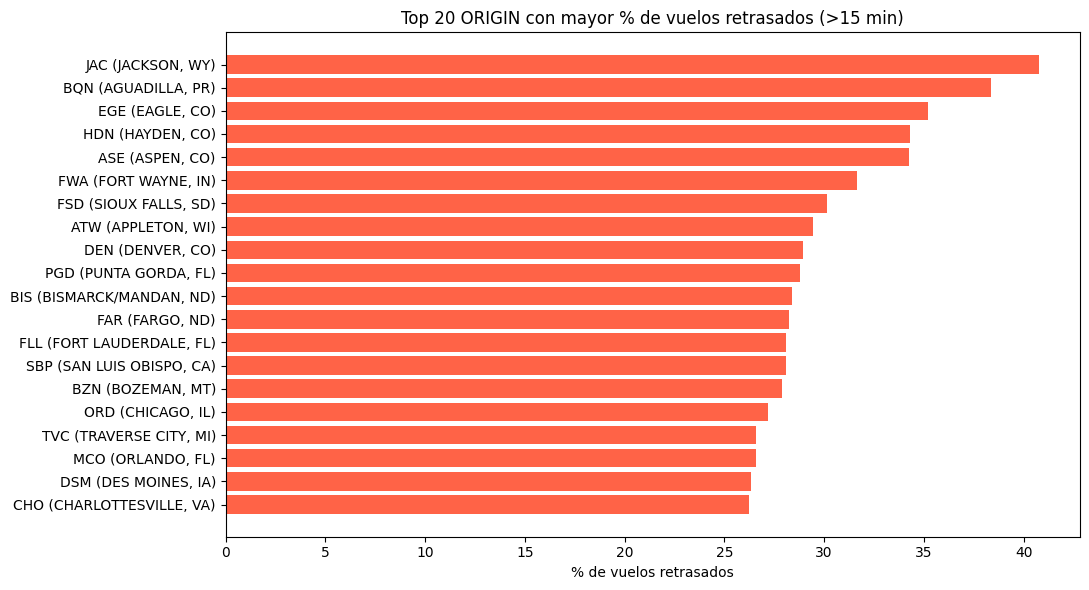

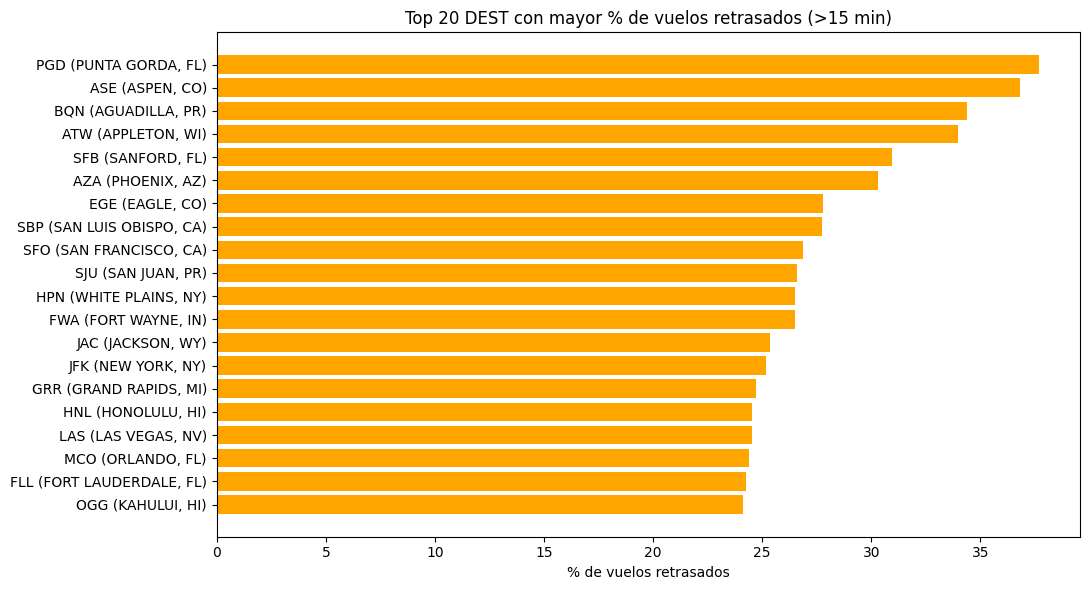

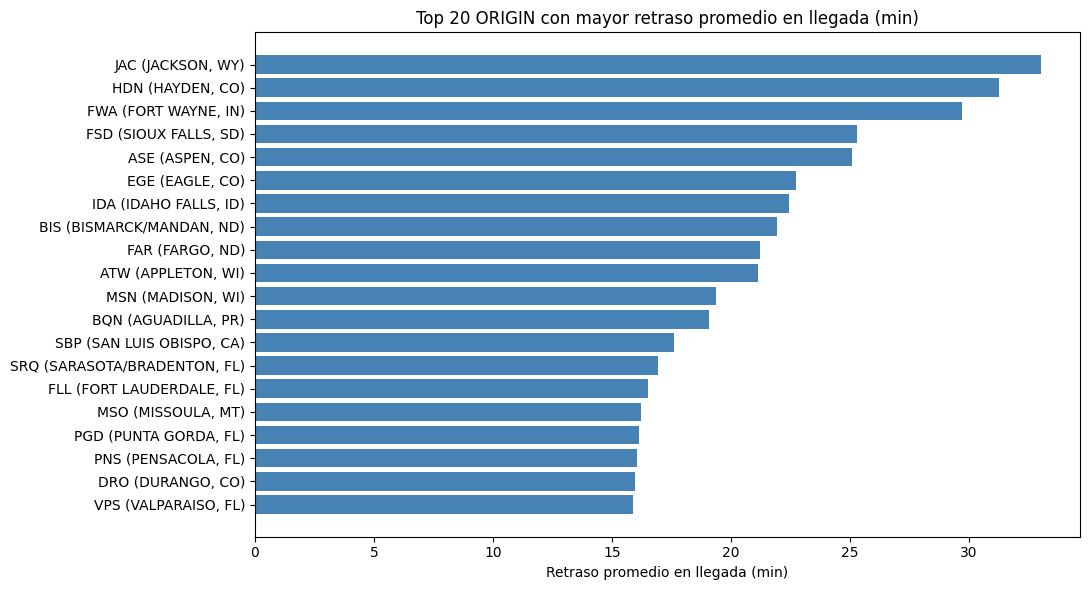

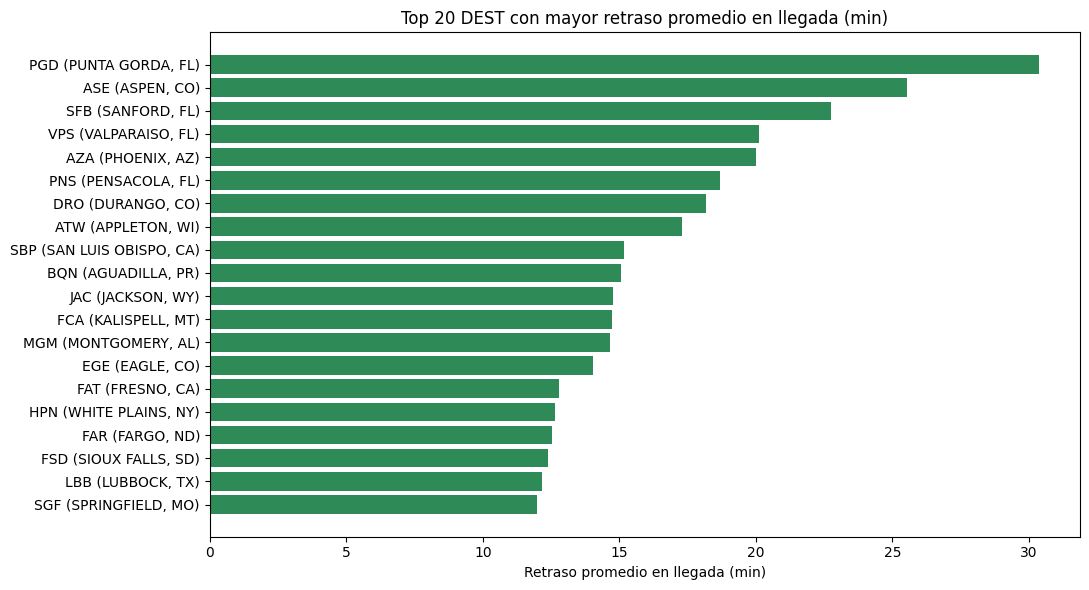

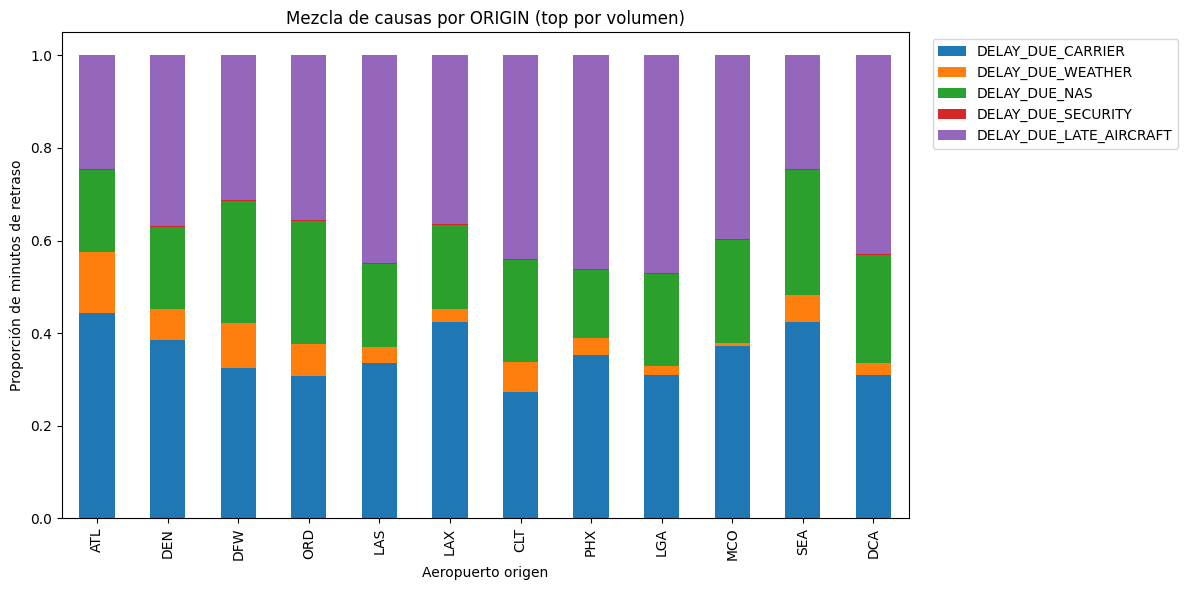

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parámetros ----------
UMBRAL_VUELOS = 200      # cambia a gusto
UMBRAL_MIN_RETRASO = 15  # definición de "retraso"

# Asegurar columnas esenciales
cols_needed = ["ORIGIN","DEST","ORIGIN_CITY","DEST_CITY",
               "FL_NUMBER","DEP_DELAY","ARR_DELAY"]
assert all(c in flights_merged.columns for c in cols_needed)

# ---------- Métricas por ORIGIN ----------
origin_summary = flights_merged.groupby(["ORIGIN","ORIGIN_CITY"]).agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean"),
    pct_retrasados=("ARR_DELAY", lambda x: (x > UMBRAL_MIN_RETRASO).mean()*100)
).reset_index()

origin_summary = origin_summary.query("total_vuelos >= @UMBRAL_VUELOS")

# ---------- Métricas por DEST ----------
dest_summary = flights_merged.groupby(["DEST","DEST_CITY"]).agg(
    total_vuelos=("FL_NUMBER","count"),
    promedio_dep_delay=("DEP_DELAY","mean"),
    promedio_arr_delay=("ARR_DELAY","mean"),
    pct_retrasados=("ARR_DELAY", lambda x: (x > UMBRAL_MIN_RETRASO).mean()*100)
).reset_index()

dest_summary = dest_summary.query("total_vuelos >= @UMBRAL_VUELOS")

# ---------- Tablas TOP 20 ----------
top_origin_pct = origin_summary.sort_values("pct_retrasados", ascending=False).head(20)
top_dest_pct   = dest_summary.sort_values("pct_retrasados", ascending=False).head(20)

top_origin_avg = origin_summary.sort_values("promedio_arr_delay", ascending=False).head(20)
top_dest_avg   = dest_summary.sort_values("promedio_arr_delay", ascending=False).head(20)

display(top_origin_pct.head(10))
display(top_dest_pct.head(10))
display(top_origin_avg.head(10))
display(top_dest_avg.head(10))

# ---------- Gráficos ----------
plt.figure(figsize=(11,6))
plt.barh(top_origin_pct["ORIGIN"] + " (" + top_origin_pct["ORIGIN_CITY"] + ")",
         top_origin_pct["pct_retrasados"], color="tomato")
plt.gca().invert_yaxis()
plt.title("Top 20 ORIGIN con mayor % de vuelos retrasados (>15 min)")
plt.xlabel("% de vuelos retrasados")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,6))
plt.barh(top_dest_pct["DEST"] + " (" + top_dest_pct["DEST_CITY"] + ")",
         top_dest_pct["pct_retrasados"], color="orange")
plt.gca().invert_yaxis()
plt.title("Top 20 DEST con mayor % de vuelos retrasados (>15 min)")
plt.xlabel("% de vuelos retrasados")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,6))
plt.barh(top_origin_avg["ORIGIN"] + " (" + top_origin_avg["ORIGIN_CITY"] + ")",
         top_origin_avg["promedio_arr_delay"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 20 ORIGIN con mayor retraso promedio en llegada (min)")
plt.xlabel("Retraso promedio en llegada (min)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,6))
plt.barh(top_dest_avg["DEST"] + " (" + top_dest_avg["DEST_CITY"] + ")",
         top_dest_avg["promedio_arr_delay"], color="seagreen")
plt.gca().invert_yaxis()
plt.title("Top 20 DEST con mayor retraso promedio en llegada (min)")
plt.xlabel("Retraso promedio en llegada (min)")
plt.tight_layout()
plt.show()

# ---------- (Opcional) Causas por aeropuerto (ORIGIN) ----------
cause_cols = ["DELAY_DUE_CARRIER","DELAY_DUE_WEATHER","DELAY_DUE_NAS",
              "DELAY_DUE_SECURITY","DELAY_DUE_LATE_AIRCRAFT"]
if all(c in flights_merged.columns for c in cause_cols):
    origin_cause = (flights_merged.groupby("ORIGIN")[cause_cols]
                    .sum().loc[origin_summary["ORIGIN"]])
    # Pasar a proporciones por aeropuerto para comparar
    origin_cause_share = origin_cause.div(origin_cause.sum(axis=1), axis=0).fillna(0)

    # Mostrar top 12 por volumen
    top12_orig_vol = (origin_summary.sort_values("total_vuelos", ascending=False)
                      .head(12)["ORIGIN"])
    oc_plot = origin_cause_share.loc[top12_orig_vol]

    ax = oc_plot.plot(kind="bar", stacked=True, figsize=(12,6))
    plt.title("Mezcla de causas por ORIGIN (top por volumen)")
    plt.ylabel("Proporción de minutos de retraso")
    plt.xlabel("Aeropuerto origen")
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()


#  Orígenes y destinos con más retrasos

##  Top 20 ORIGIN con mayor % de vuelos retrasados (>15 min)
- **JAC (Jackson Hole, 41%)**, **BQN (Aguadilla, 39%)** y **EGE (Eagle, 36%)** destacan.  
- Alta frecuencia de retrasos por clima (Eagle, Aspen) o limitaciones operativas (BQN, regional).  
- Ejemplo: salir de JAC implica ~40% de probabilidad de retraso >15 min → crítico para la puntualidad.  



## Top 20 DEST con mayor % de vuelos retrasados (>15 min)
- **PGD (Punta Gorda, 37%)**, **ASE (Aspen, 36%)** y **BQN (Aguadilla, 35%)** concentran más retrasos.  
- Aeropuertos turísticos/regionales absorben peor las demoras.  
- Volar a PGD: más de 1 de cada 3 vuelos llega con retraso.  


##  Top 20 ORIGIN con mayor retraso promedio en llegada (min)
- **JAC (32 min)**, **HDN (Hayden, 30 min)** y **FWA (Fort Wayne, 28 min)**.  
- Aquí no solo hay más retrasos, sino que además son más largos.  
- Ejemplo: en FSD (Sioux Falls), aunque no son tan frecuentes, cuando ocurren duran ~27 min.  



##  Top 20 DEST con mayor retraso promedio en llegada (min)
- **PGD (31 min)**, **ASE (25 min)** y **SFB (Sanford, 23 min)**.  
- PGD vuelve a destacar: alto % de vuelos retrasados y demoras prolongadas.  
- Volar a PGD implica mayor probabilidad y duración de retraso.  



## Mezcla de causas por Origen
Cada barra representa un aeropuerto de origen con alto volumen de vuelos (ej. ATL, DEN, DFW, ORD, LAX).  
La barra se divide por **causas de retraso**:  
- 🔵 Carrier (aerolínea).  
- 🟠 Weather (clima).  
- 🟢 NAS (sistema aéreo nacional).  
- 🔴 Security (mínimo).  
- 🟣 Late aircraft (efecto cascada).  



##  Hallazgos clave por aeropuerto
- **ATL (Atlanta):** Carrier (~45%) y NAS (~30%), poco clima → problemas internos y congestión aérea.  
- **DEN (Denver):** similar, pero con más Weather (~10%) → nevadas/tormentas influyen.  
- **DFW (Dallas):** balance entre Carrier (33%), NAS (25%) y Late Aircraft (40%).  
- **ORD (Chicago O’Hare):** como DFW, pero más Weather (~12%) → clima invernal.  
- **LAX (Los Ángeles):** Late Aircraft (~40%), Carrier (~35%) → efecto dominó de conexiones.  
- **CLT (Charlotte):** Carrier (~45%), Late Aircraft (~35%) → retrasos ligados a American Airlines.  
- **SEA (Seattle):** Carrier (~40%), NAS (~35%), Late Aircraft (~20%) → más congestión aérea nacional.  

## Patrón global
- **Carrier + Late Aircraft = >70%** de retrasos en casi todos los grandes aeropuertos.  
- **Weather** relevante en Denver y Chicago.  
- **NAS** pesa más en hubs de gran tráfico (ATL, SEA, ORD).  
- **Security** marginal (`<1%`).  


##  Ejemplo comparativo
- **ATL (Atlanta):** retrasos por aerolínea o congestión, no tanto por clima.  
- **DEN (Denver):** mayor peso del clima en comparación con otros hubs.  
- **LAX (Los Ángeles):** casi la mitad de retrasos por Late Aircraft → efecto dominó.  


## Conclusión
Sí, existen orígenes y destinos con mayor concentración de retrasos:  
- **Orígenes críticos:** JAC (Wyoming), BQN (Puerto Rico), EGE/HDN/ASE (Colorado).  
- **Destinos críticos:** PGD (Florida), ASE (Colorado), BQN (Puerto Rico).  
- **Grandes hubs (ATL, DEN, ORD):** no lideran en % de retrasos, pero por volumen afectan a más pasajeros.  

##  Insight clave
- Por **probabilidad de retraso:** destacan JAC y PGD.  
- Por **duración del retraso:** destacan PGD y JAC.  
- Los aeropuertos grandes (ATL, DEN, DFW) → no los peores en porcentaje, pero sí en **impacto global** por su enorme volumen de vuelos.  
